In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn_image as isns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerBase
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
import scienceplots
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from statannotations.Annotator import Annotator
import textalloc
import itertools
from scipy import stats

In [2]:
# paper style
plt.style.use(['science', 'notebook'])
# plt.rcParams.update({'figure.dpi': '150'})

In [3]:
class MultipleRectanglesHandler(HandlerBase):
    def __init__(self, colors):
        self.colors = colors
        super().__init__()

    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        # Create as many rectangles as there are colors
        rects = []
        for i, color in enumerate(self.colors):
            rect = Rectangle([x0 + (width / len(self.colors)) * i, y0], 
                                     width / len(self.colors), height, 
                                     facecolor=color, edgecolor=None, 
                                     transform=trans)
            rects.append(rect)
        return rects

In [4]:
# Function to calculate the luminance of a color
def get_luminance(color):
    # Convert color to RGB (assuming it's in hex format if it's a string)
    if isinstance(color, str):
        color = plt.colors.to_rgb(color)  # Converts hex to RGB if necessary
    # Calculate luminance using a formula that accounts for human eye sensitivity
    luminance = 0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]
    return luminance

In [5]:
def make_color_gradient(color1, color2, n):
    # Convert color to RGB (assuming it's in hex format if it's a string)
    if isinstance(color1, str):
        color1 = mcolors.to_rgb(color1)  # Converts hex to RGB if necessary
    if isinstance(color2, str):
        color2 = mcolors.to_rgb(color2)  # Converts hex to RGB if necessary
    # Create a color gradient
    gradient = [color1]
    for i in range(1, n):
        # Calculate the intermediate color
        new_color = [color1[j] + (color2[j] - color1[j]) * i / (n - 1) for j in range(3)]
        gradient.append(new_color + [1])
    return gradient

In [6]:
RG_DATASET_COLOR = 'dodgerblue'
RGID_DATASET_COLOR = 'deepskyblue'
IDRBIND_DATASET_COLOR= 'limegreen'
FUZZY_DATASET_COLOR = 'orange'
SCANIDR_DATASET_COLOR = 'slateblue'
DECOYS_DATASET_COLOR = 'darkgrey'

In [7]:
LIGHT_GREY = mcolors.to_rgba('lightgrey')
CAPRI_COLORS_RG = [LIGHT_GREY] + make_color_gradient('white', RG_DATASET_COLOR, 5)[-3:]
CAPRI_COLORS_RGID = [LIGHT_GREY] + make_color_gradient('white', RGID_DATASET_COLOR, 5)[-3:]
CAPRI_COLORS_IDRBIND = [LIGHT_GREY] + make_color_gradient('white', IDRBIND_DATASET_COLOR, 5)[-3:]
CAPRI_COLORS_FUZZY = [LIGHT_GREY] + make_color_gradient('white', FUZZY_DATASET_COLOR, 5)[-3:]
CAPRI_COLORS_SCANIDR = [LIGHT_GREY] + make_color_gradient('white', SCANIDR_DATASET_COLOR, 5)[-3:]

In [29]:
df_dockq_fuz = pd.read_csv('../data/fuzidp_uniprot_dockq.csv')
df_dockq_fuz_notail = pd.read_csv('../data/fuzidp_uniprot_dockq_no-tails.csv')
df_dockq = pd.merge(
    df_dockq_fuz,
    df_dockq_fuz_notail,
    on=['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'recycle', 'reference_model'],
    how='outer',
    suffixes=('', '_notail'),
)

df_dockq_rg = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_dockq_recycle.csv')
df_dockq_rg_notail = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_dockq_notails_recycle.csv')
df_dockq_rg = pd.merge(
    df_dockq_rg,
    df_dockq_rg_notail,
    on=['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'recycle', 'reference_model'],
    how='outer',
    suffixes=('', '_notail'),
)
df_dockq_rgid = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_iface_iupred_disorder_half.csv')
df_dockq_rgid = pd.merge(
    df_dockq_rg,
    df_dockq_rgid,
    on=['pdb_id', 'idp_id', 'receptor_id'],
    how='inner',
)

df_dockq_idrbind = pd.read_csv('../data/idrbind_uniprot_dockq_recycles.csv')
df_dockq_idrbind_notail = pd.read_csv('../data/idrbind_uniprot_dockq_recycles_notails.csv')
df_dockq_idrbind = pd.merge(
    df_dockq_idrbind,
    df_dockq_idrbind_notail,
    on=['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'recycle', 'reference_model'],
    how='outer',
    suffixes=('', '_notail'),
)

df_dockq = pd.concat([
    df_dockq.assign(exp='delim_idp', dataset='Fuzzy'),
    # df_dockq_frag.assign(exp='fragmented', dataset='Fuzzy'),
    df_dockq_idrbind.assign(exp='delim_idp', dataset='IDRBind'),
    df_dockq_rgid.assign(exp='delim_idp', dataset='Rg', is_disorder=True),
    df_dockq_rg.assign(exp='delim_idp', dataset='Rg'),
], ignore_index=True)
print(df_dockq.shape)
df_dockq.head()

(56200, 67)


,pdb_id,idp_id,receptor_id,relaxed,rank,model_name,model,seed,recycle,reference_model,...,receptor_core_true,receptor_rim_true,buried_surface_area,idp_helices,idp_sheets,receptor_helices,receptor_sheets,idp_iupred_long,receptor_iupred_long,is_disorder
0,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df_pdockq_fuz = pd.read_csv('../data/fuzidp_uniprot_pdockq.csv')
df_pdockq_rg = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_pdockq_recycle.csv')
df_pdockq_idrbind = pd.read_csv('../data/idrbind_uniprot_pdockq_recycles.csv')
df_pdockq_rg_decoys = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_pdockq_fullidp_decoy.csv')

df_pdockq = pd.concat([
    df_pdockq_fuz.assign(exp='delim_idp', dataset='Fuzzy'),
    df_pdockq_idrbind.assign(exp='delim_idp', dataset='IDRBind'),
    df_pdockq_rg.assign(exp='delim_idp', dataset='Rg'),
    df_pdockq_rg_decoys.assign(exp='delim_idp', dataset='Decoys'),
], ignore_index=True)
print(df_pdockq.shape)
df_pdockq.head()

(1980, 21)


,pdb_id,idp_id,receptor_id,relaxed,rank,model_name,model,seed,recycle,n_contacts,...,receptor_iface_residx,plddt_iface,plddt_iface_mean,pae_iface_mean,pae_idp_iface,pae_receptor_iface,pdockq_elof,pdockq2_elof,exp,dataset
0,1KDX,B,A,False,1,alphafold2_multimer_v2,3,0,NaN,37,...,"[64, 65, 66, 67, 68, 69, 71, 72, 10, 75, 76, 1...","[83.12, 89.12, 91.12, 92.62, 92.69, 92.44, 93....",91.044667,3.999927,"[5.546975308641976, 4.631851851851852, 4.38438...","[2.704821428571429, 2.4358928571428575, 2.5566...",0.289403,0.496977,delim_idp,Fuzzy
1,1KDX,B,A,False,3,alphafold2_multimer_v2,1,0,NaN,39,...,"[64, 65, 67, 68, 69, 71, 72, 73, 10, 75, 76, 1...","[80.94, 87.62, 87.69, 91.75, 92.81, 93.12, 94....",90.729677,4.247760,"[6.158271604938271, 5.103765432098765, 4.74376...","[2.9316071428571426, 2.7167857142857144, 2.749...",0.303482,0.461750,delim_idp,Fuzzy
2,1KDX,B,A,False,2,alphafold2_multimer_v2,4,0,NaN,38,...,"[64, 65, 66, 67, 68, 69, 71, 72, 10, 75, 12, 1...","[80.62, 87.38, 89.5, 93.12, 92.31, 93.06, 93.9...",91.070000,4.293373,"[5.979938271604938, 5.409876543209877, 4.99055...","[2.997678571428571, 2.6678571428571423, 2.7682...",0.299125,0.461811,delim_idp,Fuzzy
3,1KDX,B,A,False,5,alphafold2_multimer_v2,5,0,NaN,38,...,"[64, 65, 66, 67, 68, 69, 71, 72, 73, 75, 76, 1...","[77.5, 84.69, 87.62, 91.69, 90.69, 91.88, 92.7...",89.260645,4.569158,"[7.1449382716049366, 5.48641975308642, 4.925, ...","[3.357857142857143, 3.1857142857142855, 3.1882...",0.274028,0.401134,delim_idp,Fuzzy
4,2KJE,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,78,...,"[5, 8, 9, 12, 15, 16, 30, 31, 34, 35, 37, 38, ...","[37.69, 39.59, 41.41, 46.38, 48.56, 50.25, 47....",62.239038,14.869037,"[17.844402173913046, 16.375815217391306, 15.30...","[14.964642857142858, 14.236785714285716, 13.73...",0.119635,0.015956,delim_idp,Fuzzy


In [31]:
df_pdockq.groupby(['exp', 'dataset'])[['n_contacts', 'plddt_iface_mean', 'pae_iface_mean']].describe()

n_contacts                                               \
                       count       mean        std  min   25%   50%   75%   
exp       dataset                                                           
delim_idp Decoys       360.0  46.847222  30.017293  0.0  29.0  45.0  61.0   
          Fuzzy        225.0  51.222222  25.587986  0.0  36.0  45.0  64.0   
          IDRBind      365.0  56.183562  36.345968  6.0  33.0  45.0  71.0   
          Rg          1030.0  75.679612  43.844259  0.0  49.0  69.0  90.0   

                         plddt_iface_mean             ...             \
                     max            count       mean  ...        75%   
exp       dataset                                     ...              
delim_idp Decoys   198.0            338.0  63.038169  ...  68.139792   
          Fuzzy    145.0            223.0  76.423010  ...  85.113760   
          IDRBind  245.0            365.0  80.471158  ...  90.495652   
          Rg       347.0           1017.0  80.360450  ...  92.035455   

                             pae_iface_mean                                 \
                         max          count       mean       std       min   
exp       dataset                                                            
delim_idp Decoys   96.822258          338.0  20.315894  4.802922  4.682084   
          Fuzzy    91.948421          223.0  10.512543  4.915335  3.999927   
          IDRBind  98.408182          365.0  10.690624  5.025427  2.869145   
          Rg       98.611667         1017.0  12.073421  6.964557  2.530509   

                                                               
                         25%        50%        75%        max  
exp       dataset                                              
delim_idp Decoys   17.166674  20.290292  23.825716  30.160844  
          Fuzzy     6.310186   9.640881  13.428299  29.239802  
          IDRBind   6.314351   9.641139  14.752645  24.106951  
          Rg        6.207558  10.093488  17.027217  31.365034  

[4 rows x 24 columns]

In [32]:
df_score_rg = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_scores_recycle.csv')
df_score_rg_decoy = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_scores_fullidp_decoy.csv')
df_score_idrbind = pd.read_csv('../data/idrbind_uniprot_scores_recycles.csv')
df_score_fuzzy = pd.read_csv('../data/fuzidp_uniprot_scores.csv')

df_score = pd.concat([
    df_score_fuzzy.assign(exp='delim_idp', dataset='Fuzzy'),
    df_score_idrbind.assign(exp='delim_idp', dataset='IDRBind'),
    df_score_rg.assign(exp='delim_idp', dataset='Rg'),
    df_score_rg_decoy.assign(exp='delim_idp', dataset='Decoys'),
], ignore_index=True)
print(df_score.shape)
df_score.head()

(2000, 43)


,pdb_id,idp_id,receptor_id,plddt_idp,plddt_receptor,pae_idp_idp_mean,pae_idp_idp_min,pae_idp_idp_max,pae_receptor_receptor_mean,pae_receptor_receptor_min,...,pae_receptor_idp_raw,jobname,rank,model_name,model,seed,exp,dataset,idp_id_af,idp_fragment
0,2LPB,B,A,"[41.34, 41.38, 41.88, 50.88, 48.78, 46.25, 45....","[38.59, 44.19, 56.97, 69.56, 70.69, 76.56, 82....","[19.16441176470588, 17.779117647058825, 16.975...","[0.76, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...","[30.05, 30.05, 29.95, 29.72, 29.86, 29.55, 28....","[9.326296296296299, 8.465679012345676, 7.38740...","[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...",...,"[[25.94, 25.67, 24.14, 23.94, 23.33, 23.3, 21....",2LPB_B_A,1,alphafold2_multimer_v2,5,0,delim_idp,Fuzzy,NaN,NaN
1,2LPB,B,A,"[39.16, 43.16, 45.91, 49.41, 50.0, 49.91, 44.2...","[44.59, 44.31, 56.41, 59.81, 67.19, 73.56, 78....","[18.912058823529414, 17.459705882352946, 17.08...","[0.76, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...","[29.14, 28.95, 29.31, 28.92, 28.56, 28.92, 28....","[9.778518518518519, 9.1, 8.212592592592591, 7....","[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...",...,"[[27.0, 26.27, 26.19, 25.53, 24.44, 24.81, 23....",2LPB_B_A,2,alphafold2_multimer_v2,2,0,delim_idp,Fuzzy,NaN,NaN
2,2LPB,B,A,"[38.72, 44.16, 42.03, 47.94, 48.91, 46.06, 43....","[51.84, 53.81, 55.69, 61.53, 66.56, 73.69, 81....","[19.701764705882358, 18.319705882352938, 18.26...","[0.76, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...","[30.14, 29.38, 30.16, 30.14, 29.91, 29.62, 28....","[8.989259259259258, 8.428024691358027, 7.43938...","[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...",...,"[[26.06, 25.48, 25.33, 23.97, 23.2, 23.44, 20....",2LPB_B_A,3,alphafold2_multimer_v2,1,0,delim_idp,Fuzzy,NaN,NaN
3,2LPB,B,A,"[43.38, 49.84, 48.78, 50.69, 49.47, 48.0, 45.1...","[49.34, 52.0, 59.09, 63.53, 69.12, 71.56, 77.7...","[19.578529411764706, 18.295882352941174, 17.81...","[0.76, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...","[28.98, 29.28, 29.3, 29.06, 28.48, 28.08, 27.6...","[9.305308641975309, 8.566296296296299, 7.48234...","[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...",...,"[[25.53, 25.27, 25.19, 24.06, 22.94, 23.64, 20...",2LPB_B_A,4,alphafold2_multimer_v2,3,0,delim_idp,Fuzzy,NaN,NaN
4,2LPB,B,A,"[44.06, 50.53, 48.12, 53.38, 52.38, 50.38, 46....","[50.03, 50.03, 55.38, 66.44, 71.38, 75.94, 82....","[19.34823529411765, 18.383823529411767, 17.838...","[0.76, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...","[29.52, 29.2, 29.86, 29.11, 29.02, 28.92, 28.9...","[8.89716049382716, 8.08259259259259, 7.4330864...","[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...",...,"[[26.86, 26.41, 26.02, 25.06, 24.89, 24.06, 23...",2LPB_B_A,5,alphafold2_multimer_v2,4,0,delim_idp,Fuzzy,NaN,NaN


In [33]:
df_pdist_rg = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_pdistance_recycle.csv')
df_pdist_fuz = pd.read_csv('../data/fuzidp_uniprot_pdistance.csv')
df_pdist_idrbind = pd.read_csv('../data/idrbind_uniprot_pdistance_recycles.csv')
df_pdist_rg_decoy = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_pdistance_fullidp_decoy.csv')

df_pdist = pd.concat([
    df_pdist_rg.assign(exp='delim_idp', dataset='Rg'),
    df_pdist_fuz.assign(exp='delim_idp', dataset='Fuzzy'),
    df_pdist_idrbind.assign(exp='delim_idp', dataset='IDRBind'),
    df_pdist_rg_decoy.assign(exp='delim_idp', dataset='Decoys'),
], ignore_index=True)
print(df_pdist.shape)
df_pdist.head()

(9754, 25)


,pdb_id,idp_id,receptor_id,distogram_idp_idp_mean,distogram_idp_idp_min,distogram_idp_idp_max,distogram_receptor_receptor_mean,distogram_receptor_receptor_min,distogram_receptor_receptor_max,distogram_idp_receptor_mean,...,jobname,rank,model_name,model,seed,recycle,exp,dataset,idp_id_af,idp_fragment
0,6C0A,B,A,"[15.329130434782611, 14.937826086956523, 14.38...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.2, 22.19, 22.2, 22.2, 22.19, 22.14, 22.09,...","[18.4056338028169, 18.035211267605632, 17.8847...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.19, 22.2, 22.2, 22.22, 22.2, 22.19, 22.2, ...","[17.680434782608696, 18.038260869565217, 17.00...",...,6C0A_B_A,1,alphafold2_multimer_v2,5,0,NaN,delim_idp,Rg,NaN,NaN
1,6C0A,B,A,"[15.263478260869565, 14.93304347826087, 14.388...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.19, 22.19, 22.19, 22.16, 22.19, 22.17, 22....","[19.282112676056332, 18.584929577464784, 17.58...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.22, 22.2, 22.23, 22.2, 22.19, 22.17, 22.23...","[16.954347826086963, 16.151739130434784, 14.66...",...,6C0A_B_A,2,alphafold2_multimer_v2,4,0,0.0,delim_idp,Rg,NaN,NaN
2,6C0A,B,A,"[15.329130434782611, 14.937826086956523, 14.38...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.2, 22.19, 22.2, 22.2, 22.19, 22.14, 22.09,...","[18.4056338028169, 18.035211267605632, 17.8847...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.19, 22.2, 22.2, 22.22, 22.2, 22.19, 22.2, ...","[17.680434782608696, 18.038260869565217, 17.00...",...,6C0A_B_A,1,alphafold2_multimer_v2,5,0,3.0,delim_idp,Rg,NaN,NaN
3,6C0A,B,A,"[15.339565217391305, 14.99130434782609, 14.408...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.19, 22.19, 22.2, 22.2, 22.16, 22.17, 22.03...","[18.501408450704226, 17.99014084507042, 17.907...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.22, 22.25, 22.19, 22.2, 22.23, 22.23, 22.2...","[18.09478260869565, 18.13608695652174, 17.3386...",...,6C0A_B_A,1,alphafold2_multimer_v2,5,0,1.0,delim_idp,Rg,NaN,NaN
4,6C0A,B,A,"[15.35521739130435, 14.978695652173913, 14.397...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.19, 22.2, 22.2, 22.17, 22.17, 22.16, 22.06...","[18.44577464788732, 18.026901408450712, 17.860...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.19, 22.19, 22.2, 22.2, 22.22, 22.19, 22.22...","[17.75565217391304, 17.99, 17.014782608695654,...",...,6C0A_B_A,1,alphafold2_multimer_v2,5,0,2.0,delim_idp,Rg,NaN,NaN


In [34]:
df_score['recycle'] = np.nan

In [35]:
df_pred = pd.merge(df_dockq, df_score, on=['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'recycle', 'exp', 'dataset'], how='outer')
df_pred = pd.merge(df_pred, df_pdockq, on=['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'recycle', 'exp', 'dataset'], how='outer')
df_pred = pd.merge(df_pred, df_pdist, on=['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'recycle', 'exp', 'dataset'], how='outer')
print(df_pred.shape)
df_pred.head()

(58000, 127)


,pdb_id,idp_id,receptor_id,relaxed_x,rank,model_name,model,seed,recycle,reference_model,...,distogram_receptor_receptor_max,distogram_idp_receptor_mean,distogram_idp_receptor_min,distogram_idp_receptor_max,distogram_receptor_idp_mean,distogram_receptor_idp_min,distogram_receptor_idp_max,jobname_y,idp_id_af_y,idp_fragment_y
0,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,1.0,...,"[22.2, 22.25, 22.2, 22.23, 22.23, 22.23, 22.2,...","[20.8485294117647, 20.389411764705883, 19.7835...","[18.81, 18.11, 16.08, 16.39, 12.78, 12.52, 16....","[22.11, 22.14, 22.06, 22.05, 22.02, 21.78, 21....","[21.54345679012345, 21.499629629629634, 21.357...","[18.02, 17.16, 16.02, 14.49, 12.76, 11.26, 11....","[22.2, 22.2, 22.2, 22.22, 22.2, 22.2, 22.2, 22...",2LPB_B_A,NaN,NaN
1,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,2.0,...,"[22.2, 22.25, 22.2, 22.23, 22.23, 22.23, 22.2,...","[20.8485294117647, 20.389411764705883, 19.7835...","[18.81, 18.11, 16.08, 16.39, 12.78, 12.52, 16....","[22.11, 22.14, 22.06, 22.05, 22.02, 21.78, 21....","[21.54345679012345, 21.499629629629634, 21.357...","[18.02, 17.16, 16.02, 14.49, 12.76, 11.26, 11....","[22.2, 22.2, 22.2, 22.22, 22.2, 22.2, 22.2, 22...",2LPB_B_A,NaN,NaN
2,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,3.0,...,"[22.2, 22.25, 22.2, 22.23, 22.23, 22.23, 22.2,...","[20.8485294117647, 20.389411764705883, 19.7835...","[18.81, 18.11, 16.08, 16.39, 12.78, 12.52, 16....","[22.11, 22.14, 22.06, 22.05, 22.02, 21.78, 21....","[21.54345679012345, 21.499629629629634, 21.357...","[18.02, 17.16, 16.02, 14.49, 12.76, 11.26, 11....","[22.2, 22.2, 22.2, 22.22, 22.2, 22.2, 22.2, 22...",2LPB_B_A,NaN,NaN
3,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,4.0,...,"[22.2, 22.25, 22.2, 22.23, 22.23, 22.23, 22.2,...","[20.8485294117647, 20.389411764705883, 19.7835...","[18.81, 18.11, 16.08, 16.39, 12.78, 12.52, 16....","[22.11, 22.14, 22.06, 22.05, 22.02, 21.78, 21....","[21.54345679012345, 21.499629629629634, 21.357...","[18.02, 17.16, 16.02, 14.49, 12.76, 11.26, 11....","[22.2, 22.2, 22.2, 22.22, 22.2, 22.2, 22.2, 22...",2LPB_B_A,NaN,NaN
4,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,5.0,...,"[22.2, 22.25, 22.2, 22.23, 22.23, 22.23, 22.2,...","[20.8485294117647, 20.389411764705883, 19.7835...","[18.81, 18.11, 16.08, 16.39, 12.78, 12.52, 16....","[22.11, 22.14, 22.06, 22.05, 22.02, 21.78, 21....","[21.54345679012345, 21.499629629629634, 21.357...","[18.02, 17.16, 16.02, 14.49, 12.76, 11.26, 11....","[22.2, 22.2, 22.2, 22.22, 22.2, 22.2, 22.2, 22...",2LPB_B_A,NaN,NaN


In [36]:
df_pred.loc[df_pred['is_disorder'].notna() & df_pred['is_disorder'], 'dataset'] = 'Rg+ID'

In [37]:
# rank per seed
df_pred['seed_rank'] = df_pred.groupby(['pdb_id', 'idp_id', 'receptor_id', 'seed', 'exp', 'dataset'], dropna=False)['rank'].rank(method='dense')
print(df_pred['seed_rank'].value_counts())
print(df_pred['seed_rank'].isna().sum())

4.0    11600
3.0    11600
1.0    11600
2.0    11600
5.0    11600
Name: seed_rank, dtype: int64
0


In [38]:
# rank per seed
df_pred['seed_rank_riptm_receptor_max'] = df_pred.groupby(['pdb_id', 'idp_id', 'receptor_id', 'seed', 'exp', 'dataset'], dropna=False)['riptm_idp_max'].rank(method='dense', ascending=False)
print(df_pred['seed_rank_riptm_receptor_max'].value_counts())
print(df_pred['seed_rank_riptm_receptor_max'].isna().sum())

1.0    2350
3.0    2323
4.0    2321
2.0    2320
5.0    2286
Name: seed_rank_riptm_receptor_max, dtype: int64
46400


In [39]:
# rank per seed
df_pred['riptm_min_max'] = df_pred[['riptm_receptor_max', 'riptm_idp_max']].min(axis=1)
df_pred['seed_rank_riptm_min_max'] = df_pred.groupby(['pdb_id', 'idp_id', 'receptor_id', 'seed', 'exp', 'dataset'], dropna=False)['riptm_min_max'].rank(method='dense', ascending=False)
print(df_pred['seed_rank_riptm_min_max'].value_counts())
print(df_pred['seed_rank_riptm_min_max'].isna().sum())

2.0    2362
3.0    2321
4.0    2321
1.0    2320
5.0    2276
Name: seed_rank_riptm_min_max, dtype: int64
46400


In [40]:
df_pred[['rank', 'seed_rank', 'seed_rank_riptm_receptor_max', 'seed_rank_riptm_min_max']].corr()

,rank,seed_rank,seed_rank_riptm_receptor_max,seed_rank_riptm_min_max
rank,1.000000,1.000000,0.826111,0.696460
seed_rank,1.000000,1.000000,0.826111,0.696460
seed_rank_riptm_receptor_max,0.826111,0.826111,1.000000,0.807307
seed_rank_riptm_min_max,0.696460,0.696460,0.807307,1.000000


In [41]:
df_fuztoremove = pd.read_csv('../data/fuzidp_to_remove.csv')
df_pred = df_pred[~((df_pred['dataset'] == 'Fuzzy') & df_pred['pdb_id'].isin(df_fuztoremove['pdb_id']))]
print(df_pred.shape)

(55400, 131)


In [42]:
df_pred[df_pred['dataset'] == 'Fuzzy']['pdb_id'].nunique()

37

In [43]:
CAPRI_CLASSES = ['Incorrect', 'Acceptable', 'Medium', 'High']
def get_capri(fnat, iRMS, LRMS):
    if fnat < 0.1 or (LRMS > 10.0 and iRMS > 4.0):
        return "Incorrect"
    elif (
        (fnat >= 0.1 and fnat < 0.3)
        and (LRMS <= 10.0 or iRMS <= 4.0)
        or (fnat >= 0.3 and LRMS > 5.0 and iRMS > 2.0)
    ):
        return "Acceptable"
    elif (
        (fnat >= 0.3 and fnat < 0.5)
        and (LRMS <= 5.0 or iRMS <= 2.0)
        or (fnat >= 0.5 and LRMS > 1.0 and iRMS > 1.0)
    ):
        return "Medium"
    elif fnat >= 0.5 and (LRMS <= 1.0 or iRMS <= 1.0):
        return "High"
    else:
        return None

def get_capri_dockq(dockq):
    if 0 <= dockq < 0.23:
        return "Incorrect"
    elif dockq < 0.49:
        return "Acceptable"
    elif dockq < 0.8:
        return "Medium"
    elif 0.8 <= dockq <= 1:
        return "High"
    else:
        return None

df_pred['capri'] = df_pred[['fnat', 'irms', 'lrms']].apply(lambda x: get_capri(*x), axis=1)
df_pred['capri_dockq'] = df_pred['dockq'].apply(get_capri_dockq)
df_pred['capri_notail'] = df_pred[['fnat_notail', 'irms_notail', 'lrms_notail']].apply(lambda x: get_capri(*x), axis=1)
df_pred['capri_dockq_notail'] = df_pred['dockq_notail'].apply(get_capri_dockq)
print(df_pred['capri'].value_counts(), df_pred['capri'].isna().sum())
print(df_pred['capri_dockq'].value_counts(), df_pred['capri_dockq'].isna().sum())
print(df_pred['capri_notail'].value_counts(), df_pred['capri_notail'].isna().sum())
print(df_pred['capri_dockq_notail'].value_counts(), df_pred['capri_dockq_notail'].isna().sum())

Incorrect     22766
Acceptable    17887
Medium        11627
High           1320
Name: capri, dtype: int64 1800
Acceptable    21860
Medium        14894
Incorrect     14679
High           2167
Name: capri_dockq, dtype: int64 1800
Medium        19687
Incorrect     15808
Acceptable    14545
High           3060
Name: capri_notail, dtype: int64 2300
Medium        21073
Acceptable    17059
Incorrect     11498
High           3470
Name: capri_dockq_notail, dtype: int64 2300


In [44]:
# scanidr
df_scanidr = pd.read_csv('../data/scanidr_dockq.csv')
df_scanidr_pred = pd.read_csv('../data/scanidr_dockq.csv')
df_scanidr_pred = df_scanidr_pred[['pdb_id', 'seed', 'rank', 'combined', 'seed_rank', 'dockq', 'capri', 'iptm', 'ptm', 'index']]
df_scanidr_pred['dockq_notail'] = df_scanidr_pred['dockq']
df_scanidr_pred['capri_notail'] = df_scanidr_pred['capri']
df_scanidr_pred['capri_dockq'] = df_scanidr_pred['dockq'].apply(get_capri_dockq)
df_scanidr_pred['capri_dockq_notail'] = df_scanidr_pred['dockq_notail'].apply(get_capri_dockq)
df_scanidr_pred['reference_model'] = 1
df_scanidr_pred['seed'] = df_scanidr_pred['seed'].astype(int) - 1
# df_scanidr_pred = pd.merge(df_scanidr, df_scanidr_pred, on=['pdb_id', 'se
print(df_scanidr_pred.shape)
df_scanidr_pred.head()

(210, 15)


,pdb_id,seed,rank,combined,seed_rank,dockq,capri,iptm,ptm,index,dockq_notail,capri_notail,capri_dockq,capri_dockq_notail,reference_model
0,5NCL,0,3,0.773,3.0,0.47,Incorrect,0.781,0.741,1,0.47,Incorrect,Acceptable,Acceptable,1
1,5NCL,0,4,0.763,4.0,0.00,Incorrect,0.772,0.726,1,0.00,Incorrect,Incorrect,Incorrect,1
2,5NCL,0,5,0.751,5.0,0.53,Acceptable,0.771,0.673,1,0.53,Acceptable,Medium,Medium,1
3,5NCL,0,2,0.775,2.0,0.61,Acceptable,0.786,0.729,1,0.61,Acceptable,Medium,Medium,1
4,5NCL,0,1,0.777,1.0,0.71,Acceptable,0.788,0.734,1,0.71,Acceptable,Medium,Medium,1


In [45]:
df_pred = pd.concat([
    df_pred,
    df_scanidr_pred.assign(exp='delim_idp', dataset='Bret et al.'),
], ignore_index=True)
print(df_pred.shape)
df_pred.tail()

(55610, 136)


,pdb_id,idp_id,receptor_id,relaxed_x,rank,model_name,model,seed,recycle,reference_model,...,idp_fragment_y,seed_rank,seed_rank_riptm_receptor_max,riptm_min_max,seed_rank_riptm_min_max,capri,capri_dockq,capri_notail,capri_dockq_notail,index
55605,6GP7,NaN,NaN,NaN,2,NaN,NaN,0,NaN,1.0,...,NaN,2.0,NaN,NaN,NaN,Incorrect,Acceptable,Incorrect,Acceptable,42.0
55606,6GP7,NaN,NaN,NaN,3,NaN,NaN,0,NaN,1.0,...,NaN,3.0,NaN,NaN,NaN,Medium,High,Medium,High,42.0
55607,6GP7,NaN,NaN,NaN,5,NaN,NaN,0,NaN,1.0,...,NaN,5.0,NaN,NaN,NaN,Medium,High,Medium,High,42.0
55608,6GP7,NaN,NaN,NaN,1,NaN,NaN,0,NaN,1.0,...,NaN,1.0,NaN,NaN,NaN,Medium,High,Medium,High,42.0
55609,6GP7,NaN,NaN,NaN,4,NaN,NaN,0,NaN,1.0,...,NaN,4.0,NaN,NaN,NaN,Medium,High,Medium,High,42.0


In [46]:
df_pred['plddt_idp'] = df_pred['plddt_idp'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df_pred['plddt_receptor'] = df_pred['plddt_receptor'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df_pred['plddt_idp_mean'] = df_pred['plddt_idp'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
df_pred['plddt_receptor_mean'] = df_pred['plddt_receptor'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)

df_pred['riptm_idp'] = df_pred['riptm_idp'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df_pred['riptm_receptor'] = df_pred['riptm_receptor'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df_pred['riptm_idp_max'] = df_pred['riptm_idp'].apply(lambda x: np.max(x) if isinstance(x, list) else x)
df_pred['riptm_receptor_max'] = df_pred['riptm_receptor'].apply(lambda x: np.max(x) if isinstance(x, list) else x)

df_pred['distogram_receptor_idp_min'] = df_pred['distogram_receptor_idp_min'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df_pred['distogram_idp_receptor_min'] = df_pred['distogram_idp_receptor_min'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df_pred['distogram_idp_min'] = df_pred['distogram_receptor_idp_min'].apply(lambda x: np.min(x) if isinstance(x, list) else x)
df_pred['distogram_receptor_min'] = df_pred['distogram_receptor_idp_min'].apply(lambda x: np.min(x) if isinstance(x, list) else x)

(467, 140)
Rg             210
Rg+ID          105
IDRBind         73
Bret et al.     42
Fuzzy           37
Name: dataset, dtype: int64
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Rg vs. Bret et al.: Mann-Whitney-Wilcoxon test two-sided, P_val:4.964e-02 U_stat=3.563e+03
Fuzzy vs. Rg+ID: Mann-Whitney-Wilcoxon test two-sided, P_val:8.122e-04 U_stat=1.222e+03
IDRBind vs. Rg: Mann-Whitney-Wilcoxon test two-sided, P_val:2.621e-02 U_stat=6.326e+03
Rg+ID vs. Bret et al.: Mann-Whitney-Wilcoxon test two-sided, P_val:4.831e-02 U_stat=1.744e+03
Fuzzy vs. Rg: Mann-Whitney-Wilcoxon test two-sided, P_val:1.799e-04 U_stat=2.384e+03
IDRBind vs. Bret et al.: Mann-Whitney-Wilcoxon test two-sided, P_val:2.404e-03 U_stat=1.010e+03
Fuzzy vs. Bret et al.: Mann-Whitney-Wilcoxon test two-sided, P_val:5.497e-05 U_stat=3.660e+02


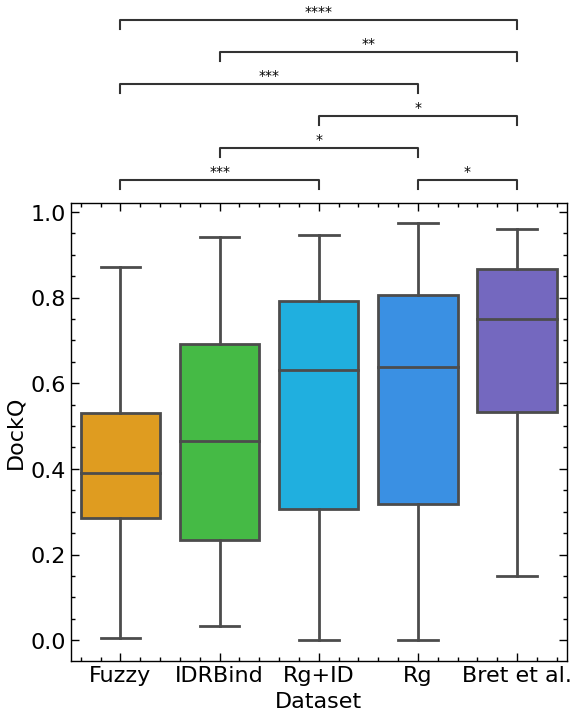

In [47]:
fig, ax = plt.subplots(figsize=(6, 8))
order = ['Fuzzy', 'IDRBind', 'Rg+ID', 'Rg', 'Bret et al.']
colors = [FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RGID_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)
                 & (df_pred['seed_rank'] == 1) & (df_pred['reference_model'] == 1) & (df_pred['dataset'].isin(order))]
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.boxplot(data=df_tmp, x='dataset', y='dockq', ax=ax, order=order, palette=colors, showfliers=False)
g.set(xlabel='Dataset', ylabel='DockQ')
# sns.despine()

pairs = [
    ('Fuzzy', 'IDRBind'),
    ('Fuzzy', 'Rg+ID'),
    ('Fuzzy', 'Rg'),
    ('Fuzzy', 'Bret et al.'),
    ('IDRBind', 'Rg+ID'),
    ('IDRBind', 'Rg'),
    ('IDRBind', 'Bret et al.'),
    ('Rg+ID', 'Rg'),
    ('Rg+ID', 'Bret et al.'),
    ('Rg', 'Bret et al.'),
]

annotator = Annotator(g, pairs, x='dataset', y='dockq', verbose=2, data=df_tmp, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2, hide_non_significant=True)
annotator.apply_and_annotate()

# g.axhline(1, ls='--', color='k', lw=0.7, alpha=0.5)

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()
fig.savefig('../figures/dockqdatasetcomparison.pdf', bbox_inches='tight')

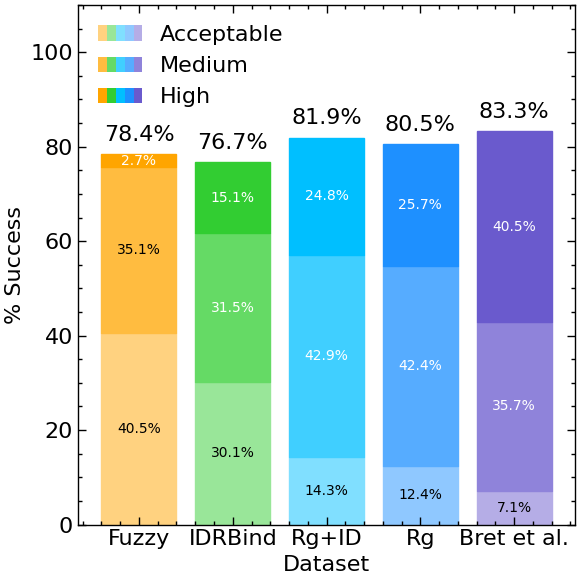

In [48]:
fig, ax = plt.subplots(figsize=(6, 6))
(df_tmp
 .groupby('dataset')['capri_dockq']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percent')
    .reset_index()
    .pivot(index='dataset', columns='capri_dockq', values='percent')[CAPRI_CLASSES[1:]]
    .reindex(CAPRI_CLASSES[1:], axis=1)
    .reindex(order, axis=0)
    .plot(kind='bar', stacked=True, rot=0, legend=False, ax=ax, width=0.8)
)

plt.ylabel('%')
plt.xlabel('Dataset')
plt.ylabel('% Success')
# plt.xticks([0, 1], ['Full IDP', 'Delimited IDP'])
plt.ylim(0, 110)

# set palettes
for i, bar in enumerate(plt.gca().patches):
    if i % len(order) == 0:
        bar.set_color(CAPRI_COLORS_FUZZY[i//len(order)+1])
    if i % len(order) == 1:
        bar.set_color(CAPRI_COLORS_IDRBIND[i//len(order)+1])
    if i % len(order) == 2:
        bar.set_color(CAPRI_COLORS_RGID[i//len(order)+1])
    if i % len(order) == 3:
        bar.set_color(CAPRI_COLORS_RG[i//len(order)+1]) 
    if i % len(order) == 4:
        bar.set_color(CAPRI_COLORS_SCANIDR[i//len(order)+1])

# text on top of bars with percentage
for p in plt.gca().patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    color = 'white' if get_luminance(p.get_facecolor()) <= 0.7 else 'black'  # Choose color based on luminance
    plt.gca().annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', color=color, fontsize=10)

x_sum = {}
for p in plt.gca().patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    x_sum[x] = x_sum.get(x, 0) + height
for p in plt.gca().patches[-len(order):]:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.gca().annotate(f'{x_sum[x]:.1f}%', (x + width / 2, y + height+2), ha='center', va='bottom', color='k', fontsize=16)

# legend
high_handle = object()
medium_handle = object()
acceptable_handle = object()
pals = [CAPRI_COLORS_FUZZY, CAPRI_COLORS_IDRBIND, CAPRI_COLORS_RGID, CAPRI_COLORS_RG, CAPRI_COLORS_SCANIDR]
ax.legend(
    title='',
    handles=[acceptable_handle, medium_handle, high_handle],
    handler_map={
        high_handle: MultipleRectanglesHandler([pal[3] for pal in pals]),
        medium_handle: MultipleRectanglesHandler([pal[2] for pal in pals]),
        acceptable_handle: MultipleRectanglesHandler([pal[1] for pal in pals]),
    },
    labels=['Acceptable', 'Medium', 'High'],
    loc='upper left'
)
    
plt.tight_layout()
fig.savefig('../figures/capridatasetcomparison.pdf', bbox_inches='tight')

In [49]:
df_tmp['dataset'].value_counts()

Rg             210
Rg+ID          105
IDRBind         73
Bret et al.     42
Fuzzy           37
Name: dataset, dtype: int64

In [50]:
df_tmp[df_tmp['capri_dockq'] == 'Incorrect'][['dataset', 'pdb_id']].drop_duplicates().to_csv('fails.csv')

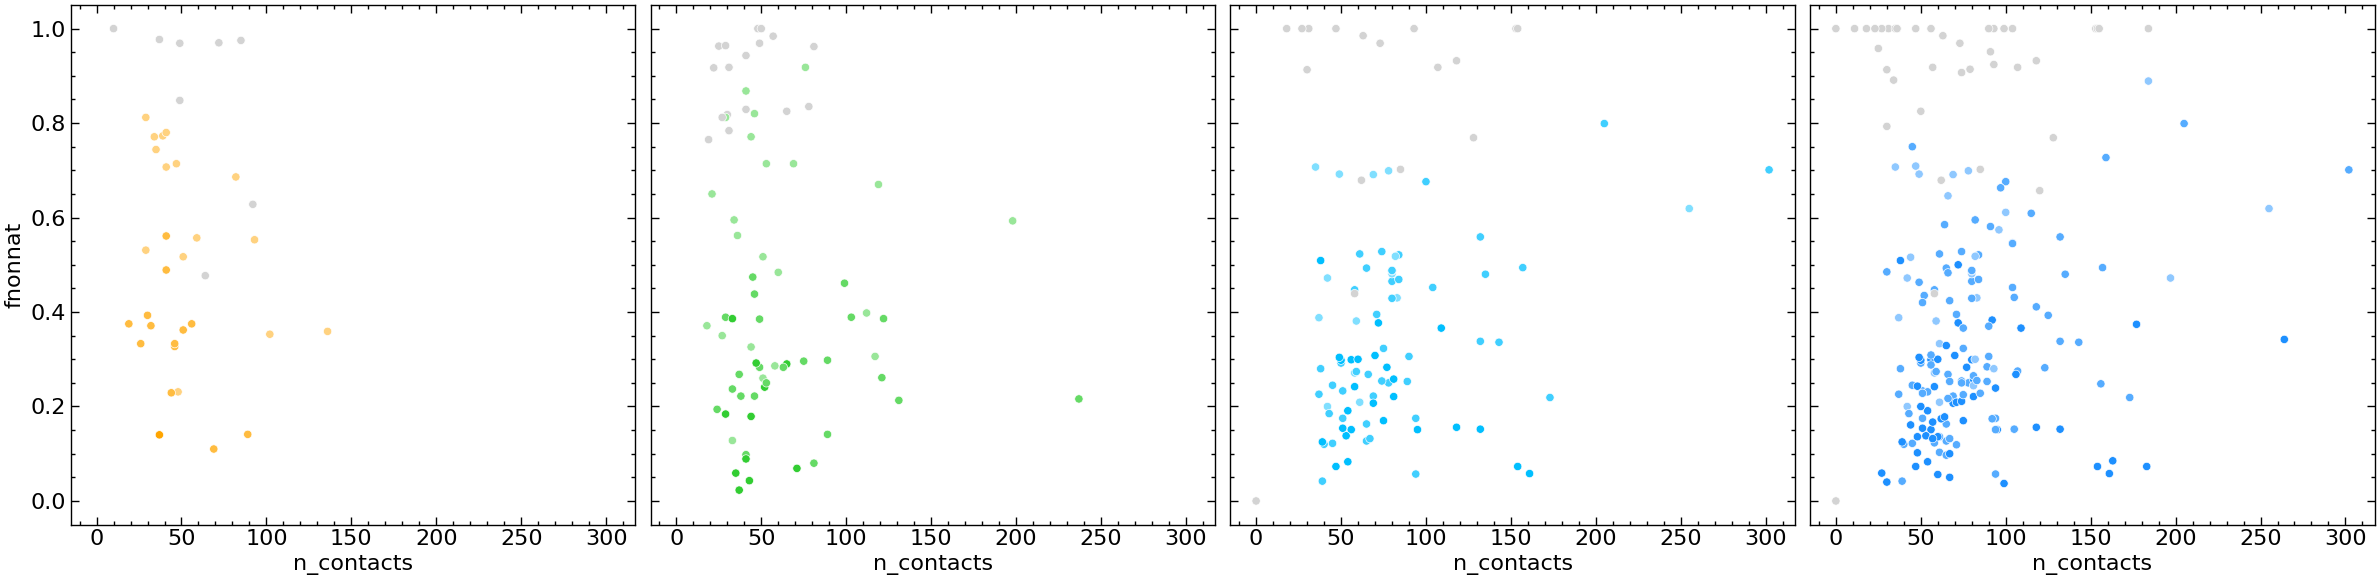

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
for i, (d, c) in enumerate(zip(
    ['Fuzzy', 'IDRBind', 'Rg+ID', 'Rg'],
    [CAPRI_COLORS_FUZZY, CAPRI_COLORS_IDRBIND, CAPRI_COLORS_RGID, CAPRI_COLORS_RG]
)):
    df_d = df_tmp[df_tmp['dataset'] == d]
    g = sns.scatterplot(
        data=df_d,
        x='n_contacts',
        y='fnonnat',
        # y=df_d['n_contacts'] * (2 * df_d['fnonnat'] - 1),  # (2 * fnonnat - 1) * n_contacts
        hue='capri_dockq',
        hue_order=CAPRI_CLASSES,
        palette=c,
        ax=ax[i],
    )
    g.legend_.remove()
    # g.axhline(0, ls='--', color='grey', lw=0.7)
    # g.axline((1, 1), (2, 2), ls='--', color='grey', lw=0.7)
    # g.axline((1, 1), (2, 0), ls='--', color='grey', lw=0.7)
    # g.axis('square')
    # g.set_ylim(-175, 175)

    # df_annot = df_d[df_d['irms'] > 10]
    # textalloc.allocate_text(
    #     fig, ax[i],
    #     x=df_annot['irms'],
    #     y=df_annot['fnonnat'],
    #     text_list=df_annot['pdb_id'],
    #     x_scatter=df_annot['irms'],
    #     y_scatter=df_annot['fnonnat'],
    #     textsize=8,
    #     linewidth=0.5,
    #     x_logscale_base=10,
    # )

plt.tight_layout()

No non overlapping boxes found


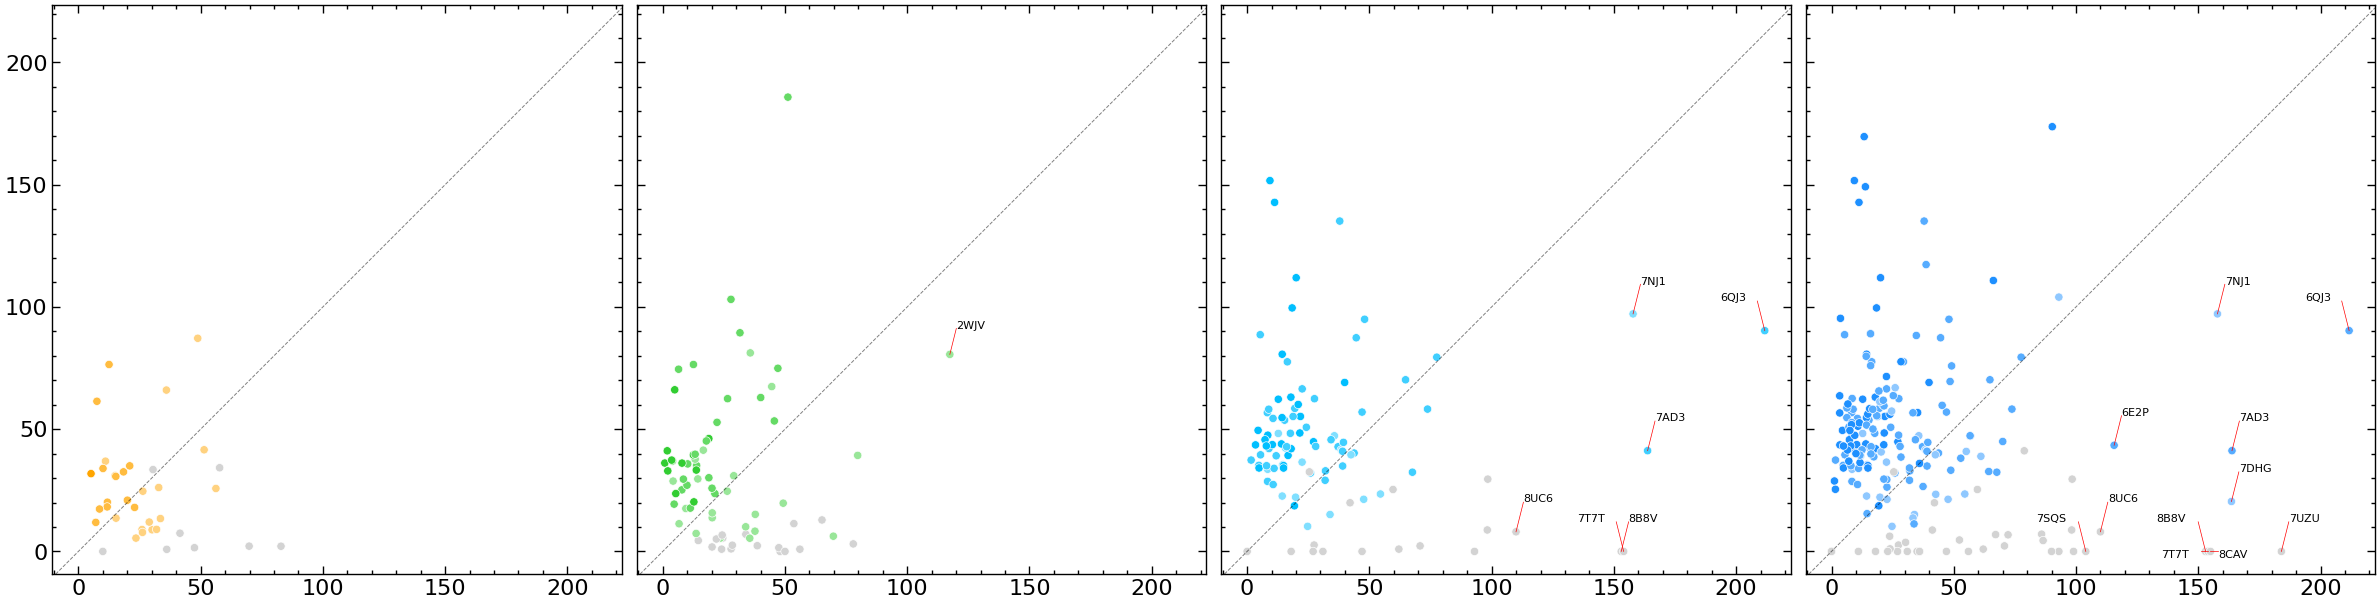

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
for i, (d, c) in enumerate(zip(
    ['Fuzzy', 'IDRBind', 'Rg+ID', 'Rg'],
    [CAPRI_COLORS_FUZZY, CAPRI_COLORS_IDRBIND, CAPRI_COLORS_RGID, CAPRI_COLORS_RG]
)):
    df_d = df_tmp[df_tmp['dataset'] == d]
    g = sns.scatterplot(
        data=df_d,
        x=df_d['fnonnat'] * df_d['n_contacts'],
        y=(1 - df_d['fnonnat']) * df_d['n_contacts'],
        hue='capri_dockq',
        hue_order=CAPRI_CLASSES,
        palette=c,
        ax=ax[i],
    )
    g.legend_.remove()
    g.axline((0, 0), (1, 1), ls='--', color='k', lw=0.7, alpha=0.5)
    g.axis('square')

    df_annot = df_d[df_d['fnonnat'] * df_d['n_contacts'] > 100]
    textalloc.allocate_text(
        fig, ax[i],
        x=df_annot['fnonnat'] * df_annot['n_contacts'],
        y=(1 - df_annot['fnonnat']) * df_annot['n_contacts'],
        text_list=df_annot['pdb_id'],
        x_scatter=df_annot['fnonnat'] * df_annot['n_contacts'],
        y_scatter=(1 - df_annot['fnonnat']) * df_annot['n_contacts'],
        textsize=8,
        linewidth=0.5,
    )

plt.tight_layout()

(2695, 140)
Rg             1050
Rg+ID           525
IDRBind         365
Decoys          360
Bret et al.     210
Fuzzy           185
Name: dataset, dtype: int64


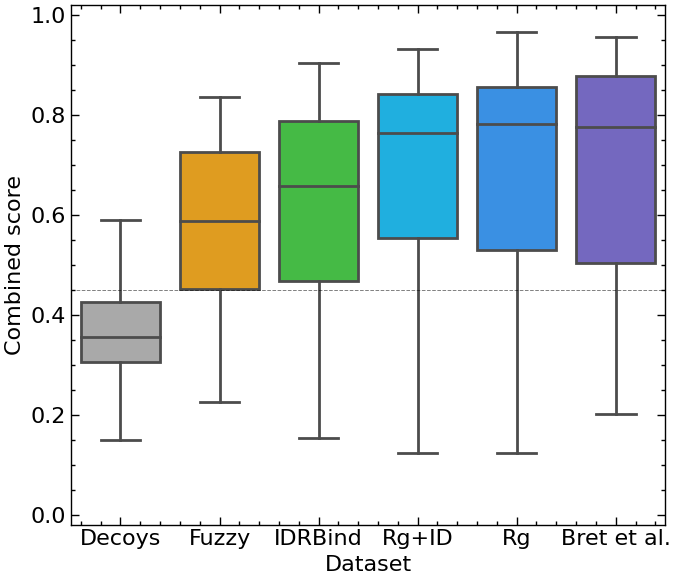

In [53]:
fig, ax = plt.subplots(figsize=(7, 6))
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg+ID', 'Rg', 'Bret et al.']
colors = [DECOYS_DATASET_COLOR, FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RGID_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.boxplot(data=df_tmp, x='dataset', y='combined', ax=ax, order=order, palette=colors, showfliers=False)
g.set(xlabel='Dataset', ylabel='Combined score')
g.axhline(0.45, ls='--', color='k', lw=0.7, alpha=0.5)
g.set_ylim(-0.02, 1.02)

pairs = [
    ('Decoys', 'Fuzzy'),
    ('IDRBind', 'Rg+ID'),
    ('Fuzzy', 'IDRBind'),
    ('Rg+ID', 'Rg'),
    ('Rg+ID', 'Bret et al.'),
    ('Rg', 'Bret et al.'),
]

annotator = Annotator(g, pairs, x='dataset', y='combined', verbose=2, data=df_tmp, order=order)
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', verbose=2, hide_non_significant=True)
# annotator.apply_and_annotate()


plt.tight_layout()
fig.savefig('../figures/combineddatasetcomparison.pdf', bbox_inches='tight')

(2695, 140)
Rg             1050
Rg+ID           525
IDRBind         365
Decoys          360
Bret et al.     210
Fuzzy           185
Name: dataset, dtype: int64


/tmp/ipykernel_360512/2605473252.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['plddt_idp_mean'] /= 100
/tmp/ipykernel_360512/2605473252.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['plddt_receptor_mean'] /= 100
/tmp/ipykernel_360512/2605473252.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

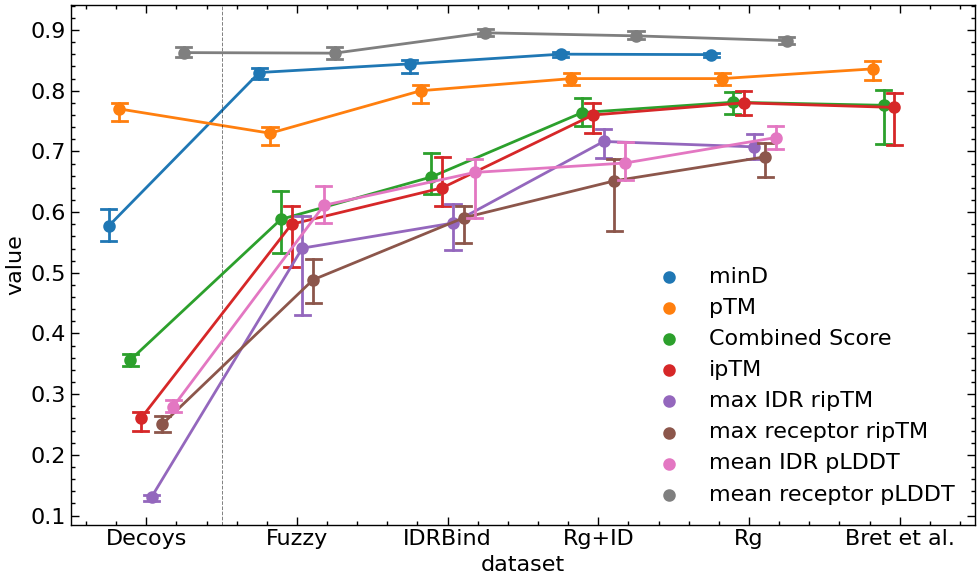

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg+ID', 'Rg', 'Bret et al.']
colors = [DECOYS_DATASET_COLOR, FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RGID_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())

df_tmp['plddt_idp_mean'] /= 100
df_tmp['plddt_receptor_mean'] /= 100
df_tmp['distogram_idp_min'] = 1 - (df_tmp['distogram_idp_min']-2)/20
df_tmp = df_tmp.melt(id_vars=['dataset'],
                     value_vars=['distogram_idp_min', 'ptm', 'combined', 'iptm', 'riptm_idp_max', 'riptm_receptor_max', 'plddt_idp_mean', 'plddt_receptor_mean'],
                     var_name='score', value_name='value')

g = sns.pointplot(data=df_tmp, x='dataset', y='value', hue='score', ax=ax, order=order, palette='tab10',
                  style='score', dodge=0.5, errwidth=1.5, capsize=0.1,
                    estimator=np.median, err_kws={'elinewidth': .5}, errorbar=('pi', 50))
plt.setp(g.axes.lines, linewidth=2)
plt.setp(g.collections, sizes=[40])
# g.set(ylim=(-0.02, 1.02))
g.axvline(0.5, ls='--', color='k', lw=0.7, alpha=0.5)
g.legend(g.get_legend_handles_labels()[0], ['minD', 'pTM', 'Combined Score', 'ipTM', 'max IDR ripTM', 'max receptor ripTM', 'mean IDR pLDDT', 'mean receptor pLDDT'], title='')
plt.tight_layout()

(1960, 140)
Rg         1050
IDRBind     365
Decoys      360
Fuzzy       185
Name: dataset, dtype: int64
Rg    20
Name: dataset, dtype: int64
Combined score 0.8608411458333332 0.512 0.05277777777777778 0.738125
ipTM 0.8733567708333333 0.42 0.07777777777777778 0.766875
pTM 0.5840590277777779 0.85 0.18611111111111112 0.355
IDR pLDDT 0.9063281249999999 42.86807692307692 0.08611111111111111 0.79375
Combined score 0.8394144144144144 0.452 0.16666666666666666 0.7513513513513513
ipTM 0.8639789789789791 0.4 0.10555555555555556 0.7351351351351352
pTM 0.384054054054054 0.6 0.8972222222222223 0.9243243243243243
IDR pLDDT 0.9122522522522523 42.411 0.09444444444444444 0.827027027027027
Combined score 0.7033127413127414 0.796 0.03783783783783784 0.47714285714285715
ipTM 0.7002548262548263 0.8 0.03783783783783784 0.4685714285714286
pTM 0.7105611325611325 0.8 0.14594594594594595 0.5666666666666667
IDR pLDDT 0.6312123552123552 75.69452830188679 0.14054054054054055 0.44


/tmp/ipykernel_360512/1800107976.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.fillna({
/tmp/ipykernel_360512/1800107976.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['pae_iface_mean'] = -df_tmp['pae_iface_mean']
/tmp/ipykernel_360512/1800107976.py:56: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_results_thresh = df_results.pivot('score', 'comparison', 'threshold')
/tmp/ipykernel_360512/1800107976.py:57: FutureWarning: In

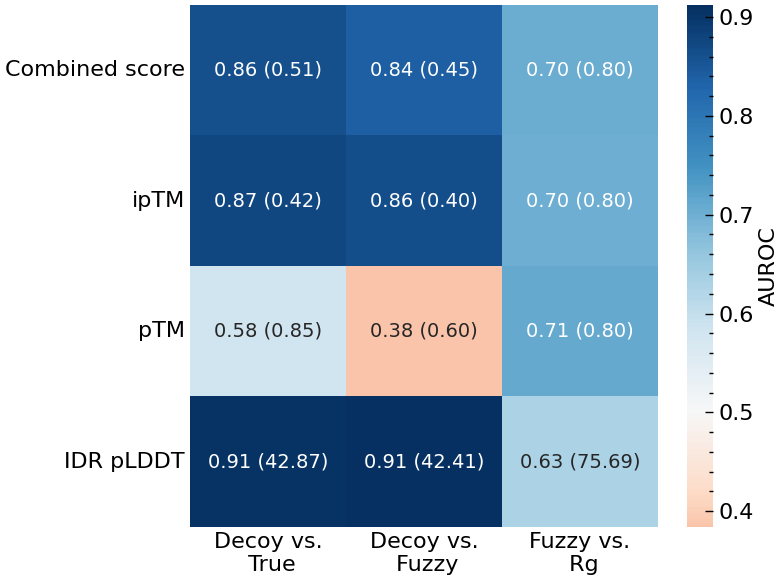

In [55]:
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg']
colors = [DECOYS_DATASET_COLOR, FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RG_DATASET_COLOR]
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
print(df_tmp[df_tmp['n_contacts'].isna()]['dataset'].value_counts())
df_tmp.fillna({
    'plddt_iface_mean': 0,
    'pae_iface_mean': 31.75,
    'n_contacts': 0,
    'pdockq_elof': 0,
    'pdockq2_elof': 0,
}, inplace=True)

# df_tmp['plddt_idp_mean'] /= 100
# df_tmp['distogram_idp_min'] = 1 - (df_tmp['distogram_idp_min']-2)/20
df_tmp['pae_iface_mean'] = -df_tmp['pae_iface_mean']

# scores = ['combined', 'iptm', 'ptm', 'riptm_idp_max', 'plddt_idp_mean', 'distogram_idp_min']
# score_titles = ['Combined\nscore', 'ipTM', 'pTM', 'max ripTM\n(IDR)', 'mean pLDDT\n(IDR)', 'minDist']
scores = ['combined', 'iptm', 'ptm', 'plddt_idp_mean']
score_titles = ['Combined score', 'ipTM', 'pTM', 'IDR pLDDT']
df_tmp = df_tmp.dropna(subset=scores, how='any')

def get_auc_and_youden(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    idx = np.argmax(tpr - fpr)
    youden = thresholds[idx]
    return roc_auc, youden, fpr[idx], tpr[idx]

results = []
# decoy vs true
for score, title in zip(scores, score_titles):
    score_auc, thresh, fp, tp = get_auc_and_youden(df_tmp['dataset'] != 'Decoys', df_tmp[score])
    print(title, score_auc, thresh, fp, tp)
    results.append([title, score_auc, thresh, 'Decoy vs. True'])

# decoy vs fuzzy
for score, title in zip(scores, score_titles):
    df_cur = df_tmp[df_tmp['dataset'].isin(['Decoys', 'Fuzzy'])]
    score_auc, thresh, fp, tp = get_auc_and_youden(df_cur['dataset'] != 'Decoys', df_cur[score])
    print(title, score_auc, thresh, fp, tp)
    results.append([title, score_auc, thresh, 'Decoy vs. Fuzzy'])

# fuzzy vs Rg
for score, title in zip(scores, score_titles):
    df_cur = df_tmp[df_tmp['dataset'].isin(['Fuzzy', 'Rg'])]
    score_auc, thresh, fp, tp = get_auc_and_youden(df_cur['dataset'] != 'Fuzzy', df_cur[score])
    print(title, score_auc, thresh, fp, tp)
    results.append([title, score_auc, thresh, 'Fuzzy vs. Rg'])

df_results = pd.DataFrame(results, columns=['score', 'auc', 'threshold', 'comparison'])
df_results_thresh = df_results.pivot('score', 'comparison', 'threshold')
df_results = df_results.pivot('score', 'comparison', 'auc')

# combine df_results and df_results_thresh such that we have AUC (Threshold) in all cells
df_results_auc = df_results.applymap(lambda x: f'{x:.2f}')
df_results_thresh = df_results_thresh.applymap(lambda x: f'{x:.2f}')
df_results_auc = df_results_auc + ' (' + df_results_thresh + ')'

df_results_auc = df_results_auc.reindex(['Decoy vs. True', 'Decoy vs. Fuzzy', 'Fuzzy vs. Rg'], axis=1)
df_results_auc = df_results_auc.reindex(score_titles, axis=0)
df_results = df_results.reindex(['Decoy vs. True', 'Decoy vs. Fuzzy', 'Fuzzy vs. Rg'], axis=1)
df_results = df_results.reindex(score_titles, axis=0)
df_results.columns = df_results.columns.str.replace('vs.', 'vs.\n')
df_results_auc.columns = df_results_auc.columns.str.replace('vs.', 'vs.\n')

fig, ax = plt.subplots(figsize=(8, 6))
g = sns.heatmap(df_results, annot=df_results_auc, fmt='', cmap='RdBu', center=0.5, cbar_kws={'label': 'AUROC'}, ax=ax,
                annot_kws={'fontsize': 14})
g.set_ylabel('')
g.set_xlabel('')
# g.set_xticklabels(g.get_xticklabels(), rotation=0, ha='right')
plt.tight_layout()
g.tick_params(axis='both', which='both', length=0)

fig.savefig('../figures/aucheatmap.pdf', bbox_inches='tight')

(1960, 140)
Rg         1050
IDRBind     365
Decoys      360
Fuzzy       185
Name: dataset, dtype: int64
Rg    20
Name: dataset, dtype: int64


/tmp/ipykernel_360512/1079524802.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.fillna({
/tmp/ipykernel_360512/1079524802.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['pae_iface_mean'] = -df_tmp['pae_iface_mean']
/tmp/ipykernel_360512/1079524802.py:50: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_results_thresh = df_results.pivot('score', 'comparison', 'threshold')
/tmp/ipykernel_360512/1079524802.py:51: FutureWarning: In

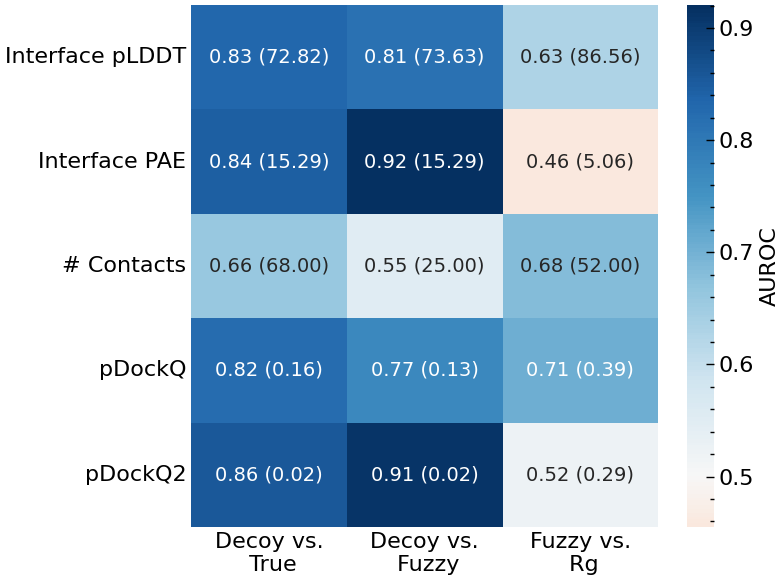

In [56]:
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg']
colors = [DECOYS_DATASET_COLOR, FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RG_DATASET_COLOR]
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
print(df_tmp[df_tmp['n_contacts'].isna()]['dataset'].value_counts())
df_tmp.fillna({
    'plddt_iface_mean': 0,
    'pae_iface_mean': 31.75,
    'n_contacts': 0,
    'pdockq_elof': 0,
    'pdockq2_elof': 0,
}, inplace=True)

# df_tmp['plddt_idp_mean'] /= 100
# df_tmp['distogram_idp_min'] = 1 - (df_tmp['distogram_idp_min']-2)/20
df_tmp['pae_iface_mean'] = -df_tmp['pae_iface_mean']

scores = ['plddt_iface_mean', 'pae_iface_mean', 'n_contacts', 'pdockq_elof', 'pdockq2_elof']
score_titles = ['Interface pLDDT', 'Interface PAE', '# Contacts', 'pDockQ', 'pDockQ2']
df_tmp = df_tmp.dropna(subset=scores, how='any')

def get_auc_and_youden(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    youden = thresholds[np.argmax(tpr - fpr)]
    return roc_auc, np.abs(youden)

results = []
# decoy vs true
for score, title in zip(scores, score_titles):
    score_auc, thresh = get_auc_and_youden(df_tmp['dataset'] != 'Decoys', df_tmp[score])
    results.append([title, score_auc, thresh, 'Decoy vs. True'])

# decoy vs fuzzy
for score, title in zip(scores, score_titles):
    df_cur = df_tmp[df_tmp['dataset'].isin(['Decoys', 'Fuzzy'])]
    score_auc, thresh = get_auc_and_youden(df_cur['dataset'] != 'Decoys', df_cur[score])
    results.append([title, score_auc, thresh, 'Decoy vs. Fuzzy'])

# fuzzy vs Rg
for score, title in zip(scores, score_titles):
    df_cur = df_tmp[df_tmp['dataset'].isin(['Fuzzy', 'Rg'])]
    score_auc, thresh = get_auc_and_youden(df_cur['dataset'] != 'Fuzzy', df_cur[score])
    results.append([title, score_auc, thresh, 'Fuzzy vs. Rg'])

df_results = pd.DataFrame(results, columns=['score', 'auc', 'threshold', 'comparison'])
df_results_thresh = df_results.pivot('score', 'comparison', 'threshold')
df_results = df_results.pivot('score', 'comparison', 'auc')

# combine df_results and df_results_thresh such that we have AUC (Threshold) in all cells
df_results_auc = df_results.applymap(lambda x: f'{x:.2f}')
df_results_thresh = df_results_thresh.applymap(lambda x: f'{x:.2f}')
df_results_auc = df_results_auc + ' (' + df_results_thresh + ')'

df_results_auc = df_results_auc.reindex(['Decoy vs. True', 'Decoy vs. Fuzzy', 'Fuzzy vs. Rg'], axis=1)
df_results_auc = df_results_auc.reindex(score_titles, axis=0)
df_results = df_results.reindex(['Decoy vs. True', 'Decoy vs. Fuzzy', 'Fuzzy vs. Rg'], axis=1)
df_results = df_results.reindex(score_titles, axis=0)
df_results.columns = df_results.columns.str.replace('vs.', 'vs.\n')
df_results_auc.columns = df_results_auc.columns.str.replace('vs.', 'vs.\n')

fig, ax = plt.subplots(figsize=(8, 6))
g = sns.heatmap(df_results, annot=df_results_auc, fmt='', cmap='RdBu', center=0.5, cbar_kws={'label': 'AUROC'}, ax=ax,
                annot_kws={'fontsize': 14})
g.set_ylabel('')
g.set_xlabel('')
# g.set_xticklabels(g.get_xticklabels(), rotation=0, ha='right')
plt.tight_layout()
g.tick_params(axis='both', which='both', length=0)

fig.savefig('../figures/aucheatmap_extra.pdf', bbox_inches='tight')

(2170, 140)
Rg             1050
IDRBind         365
Decoys          360
Bret et al.     210
Fuzzy           185
Name: dataset, dtype: int64
Bret et al.    210
Rg              20
Name: dataset, dtype: int64


/tmp/ipykernel_360512/1477964257.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.fillna({
/tmp/ipykernel_360512/1477964257.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['pae_iface_mean'] = -df_tmp['pae_iface_mean']
/tmp/ipykernel_360512/1477964257.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_results_thresh = df_results.pivot('score', 'comparison', 'threshold')
/tmp/ipykernel_360512/1477964257.py:33: FutureWarning: In

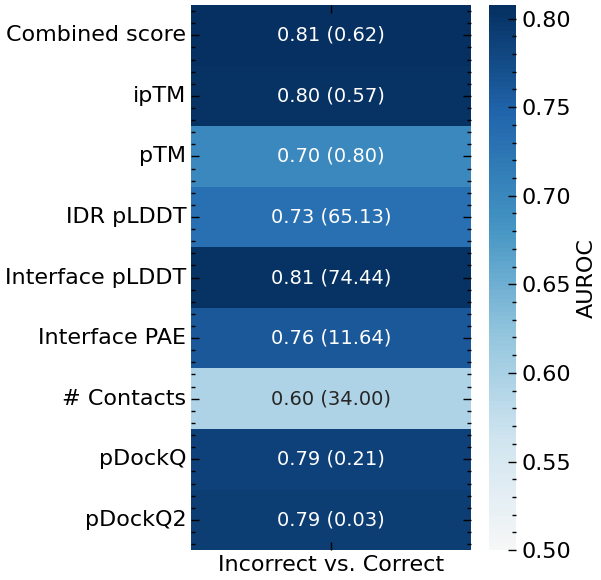

In [57]:
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg', 'Bret et al.']
colors = [DECOYS_DATASET_COLOR, FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
print(df_tmp[df_tmp['n_contacts'].isna()]['dataset'].value_counts())
df_tmp.fillna({
    'plddt_iface_mean': 0,
    'pae_iface_mean': 31.75,
    'n_contacts': 0,
}, inplace=True)

# df_tmp['plddt_idp_mean'] /= 100
# df_tmp['distogram_idp_min'] = 1 - (df_tmp['distogram_idp_min']-2)/20
df_tmp['pae_iface_mean'] = -df_tmp['pae_iface_mean']

# scores = ['combined', 'iptm', 'ptm', 'riptm_idp_max', 'plddt_idp_mean', 'distogram_idp_min']
# score_titles = ['Combined\nscore', 'ipTM', 'pTM', 'max ripTM\n(IDR)', 'mean pLDDT\n(IDR)', 'minDist']
scores = ['combined', 'iptm', 'ptm', 'plddt_idp_mean', 'plddt_iface_mean', 'pae_iface_mean', 'n_contacts', 'pdockq_elof', 'pdockq2_elof']
score_titles = ['Combined score', 'ipTM', 'pTM', 'IDR pLDDT', 'Interface pLDDT', 'Interface PAE', '# Contacts', 'pDockQ', 'pDockQ2']
df_tmp = df_tmp.dropna(subset=scores, how='any')

results = []
# incorrect vs correct
for score, title in zip(scores, score_titles):
    score_auc, thresh = get_auc_and_youden(df_tmp['capri_dockq'] != 'Incorrect', df_tmp[score])
    results.append([title, score_auc, thresh, 'Incorrect vs. Correct'])

df_results = pd.DataFrame(results, columns=['score', 'auc', 'threshold', 'comparison'])
df_results_thresh = df_results.pivot('score', 'comparison', 'threshold')
df_results = df_results.pivot('score', 'comparison', 'auc')

# combine df_results and df_results_thresh such that we have AUC (Threshold) in all cells
df_results_auc = df_results.applymap(lambda x: f'{x:.2f}')
df_results_thresh = df_results_thresh.applymap(lambda x: f'{x:.2f}')
df_results_auc = df_results_auc + ' (' + df_results_thresh + ')'

df_results_auc = df_results_auc.reindex(score_titles, axis=0)
df_results = df_results.reindex(score_titles, axis=0)
# df_results.columns = df_results.columns.str.replace('vs.', 'vs.\n')
# df_results_auc.columns = df_results_auc.columns.str.replace('vs.', 'vs.\n')

fig, ax = plt.subplots(figsize=(6, 6))
g = sns.heatmap(df_results, annot=df_results_auc, fmt='', cmap='RdBu', center=0.5, vmin=0.5, cbar_kws={'label': 'AUROC'}, ax=ax,
                annot_kws={'fontsize': 14})
g.set_ylabel('')
g.set_xlabel('')
# g.set_xticklabels(g.get_xticklabels(), rotation=0, ha='right')
plt.tight_layout()

fig.savefig('../figures/aucheatmap_capri.pdf', bbox_inches='tight')

/tmp/ipykernel_360512/1652349249.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.fillna({
/tmp/ipykernel_360512/1652349249.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['plddt_idp_mean'] /= 100


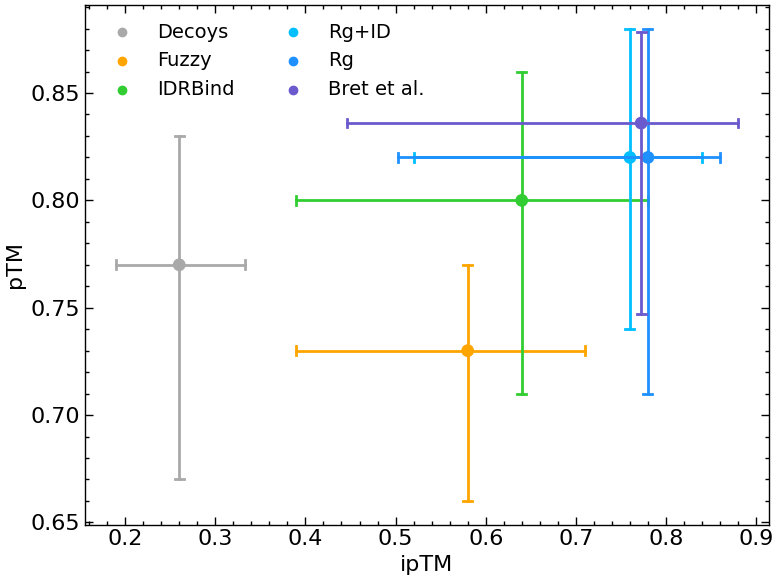

In [58]:
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg+ID', 'Rg', 'Bret et al.']
colors = [DECOYS_DATASET_COLOR, FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RGID_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
df_tmp.fillna({
    'plddt_iface_mean': 0,
    'pae_iface_mean': 31.75,
    'n_contacts': 0,
    'pdockq_elof': 0,
    'pdockq2_elof': 0,
}, inplace=True)
df_tmp['plddt_idp_mean'] /= 100
        
df_medians = df_tmp.groupby('dataset')[['combined', 'iptm', 'ptm', 'plddt_iface_mean', 'plddt_idp_mean']].median().reset_index()
df_q1 = df_tmp.groupby('dataset')[['combined', 'iptm', 'ptm', 'plddt_iface_mean', 'plddt_idp_mean']].quantile(0.25).reset_index()
df_q3 = df_tmp.groupby('dataset')[['combined', 'iptm', 'ptm', 'plddt_iface_mean', 'plddt_idp_mean']].quantile(0.75).reset_index()

fig, ax = plt.subplots(figsize=(8, 6))
g = sns.scatterplot(data=df_medians, x='iptm', y='ptm', hue='dataset', palette=colors, s=100, hue_order=order,
                    ax=ax)
for dataset, color in zip(order, colors):
    df_median_cur = df_medians[df_medians['dataset'] == dataset]
    df_q1_cur = df_q1[df_q1['dataset'] == dataset]
    df_q3_cur = df_q3[df_q3['dataset'] == dataset]
    plt.plot([df_median_cur['iptm'].values[0], df_median_cur['iptm'].values[0]],
             [df_q1_cur['ptm'].values[0], df_q3_cur['ptm'].values[0]], color=color, lw=2)
    # add small perpendicular line fragment to the end of the line
    plt.plot([df_median_cur['iptm'].values[0] - 0.005, df_median_cur['iptm'].values[0] + 0.005],
             [df_q1_cur['ptm'].values[0], df_q1_cur['ptm'].values[0]], color=color, lw=2)
    plt.plot([df_median_cur['iptm'].values[0] - 0.005, df_median_cur['iptm'].values[0] + 0.005],
                [df_q3_cur['ptm'].values[0], df_q3_cur['ptm'].values[0]], color=color, lw=2)

    plt.plot([df_q1_cur['iptm'].values[0], df_q3_cur['iptm'].values[0]],
             [df_median_cur['ptm'].values[0], df_median_cur['ptm'].values[0]], color=color, lw=2)
    # add small perpendicular line fragment to the end of the line
    plt.plot([df_q1_cur['iptm'].values[0], df_q1_cur['iptm'].values[0]],
             [df_median_cur['ptm'].values[0] - 0.002, df_median_cur['ptm'].values[0] + 0.002], color=color, lw=2)
    plt.plot([df_q3_cur['iptm'].values[0], df_q3_cur['iptm'].values[0]],
                [df_median_cur['ptm'].values[0] - 0.002, df_median_cur['ptm'].values[0] + 0.002], color=color, lw=2)

# # Fuzzy vs Rg svm
# df_svm = df_tmp[df_tmp['dataset'].isin(['Fuzzy', 'Rg'])]
# df_svm = df_svm[['combined', 'plddt_idp_mean', 'dataset']]
# df_svm['dataset'] = df_svm['dataset'].map({'Fuzzy': 0, 'Rg': 1})
# X = df_svm[['combined', 'plddt_idp_mean']]
# y = df_svm['dataset']
# clf = SVC(kernel='linear', C=0.1, class_weight='balanced')
# clf.fit(X, y)
# # auc
# y_pred = clf.decision_function(X)
# fpr, tpr, thresholds = roc_curve(y, y_pred)
# roc_auc = auc(fpr, tpr)
# print(roc_auc)
# w = clf.coef_[0]
# a = -w[0] / w[1]
# xx = np.linspace(0.55, 0.7)
# yy = a * xx - (clf.intercept_[0]) / w[1]
# print(clf.coef_, clf.intercept_)
# plt.plot(xx, yy, 'k--', lw=1)

# # Decoy vs True svm
# df_svm = df_tmp
# df_svm = df_svm[['combined', 'plddt_idp_mean', 'dataset']]
# df_svm['dataset'] = df_svm['dataset'] != 'Decoys'
# X = df_svm[['combined', 'plddt_idp_mean']]
# y = df_svm['dataset']
# clf = SVC(kernel='linear', C=1, class_weight='balanced')
# clf.fit(X, y)
# # auc
# y_pred = clf.decision_function(X)
# fpr, tpr, thresholds = roc_curve(y, y_pred)
# roc_auc = auc(fpr, tpr)
# print(roc_auc)
# w = clf.coef_[0]
# a = -w[0] / w[1]
# xx = np.linspace(0.3, 0.8)
# yy = a * xx - (clf.intercept_[0]) / w[1]
# print(clf.coef_, clf.intercept_)
# plt.plot(xx, yy, 'k--', lw=1)

plt.xlabel('ipTM')
plt.ylabel('pTM')
plt.legend(ncol=2, loc='upper left', fontsize=14, title='')
plt.tight_layout()
fig.savefig('../figures/iptmptm.pdf', bbox_inches='tight')

In [59]:
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg+ID', 'Rg', 'Bret et al.']
colors = [DECOYS_DATASET_COLOR, FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RGID_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())

df_tmp['plddt_idp_mean'] /= 100
df_tmp['distogram_idp_min'] = 1 - (df_tmp['distogram_idp_min']-2)/20

scores = ['distogram_idp_min', 'ptm', 'combined', 'iptm', 'riptm_idp_max', 'riptm_receptor_max', 'plddt_idp_mean']
df_tmp['dataset'] = df_tmp['dataset'].astype('category').cat.reorder_categories(order, ordered=True)
df_tmp['dataset'] = df_tmp['dataset'].cat.codes
df_tmp = df_tmp.dropna(subset=scores, how='any')

print(df_tmp[['dataset'] + scores].corr(method='spearman')[['dataset']])

df_tmp = df_tmp[df_tmp['dataset'] != 1]
print(df_tmp[['dataset'] + scores].corr(method='spearman')[['dataset']])

(2695, 140)
Rg             1050
Rg+ID           525
IDRBind         365
Decoys          360
Bret et al.     210
Fuzzy           185
Name: dataset, dtype: int64
                     dataset
dataset             1.000000
distogram_idp_min   0.358132
ptm                 0.179747
combined            0.427291
iptm                0.439954
riptm_idp_max       0.431835
riptm_receptor_max  0.394072
plddt_idp_mean      0.437995
                     dataset
dataset             1.000000
distogram_idp_min   0.356936
ptm                 0.126394
combined            0.401524
iptm                0.417362
riptm_idp_max       0.416056
riptm_receptor_max  0.376403
plddt_idp_mean      0.439511


/tmp/ipykernel_360512/4086608785.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['plddt_idp_mean'] /= 100
/tmp/ipykernel_360512/4086608785.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['distogram_idp_min'] = 1 - (df_tmp['distogram_idp_min']-2)/20
/tmp/ipykernel_360512/4086608785.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [60]:
def plot_roc_curve(y_true, y_score, label, color=None, dropna=True, ax=None):
    # remove nans
    if dropna:
        nan_mask = np.isnan(y_score)
        y_true = y_true[~nan_mask]
        y_score = y_score[~nan_mask]

    fpr, tpr, thresh = roc_curve(y_true, y_score)
    # roc_auc = roc_auc_score(y_true, y_score, average='weighted')
    roc_auc = auc(fpr, tpr)
    youden = np.argmax(tpr - fpr)
    sns.lineplot(x=fpr, y=tpr, label=f'{label} (AUC = {roc_auc:.3f})', color=color, ax=ax)
    plt.plot(fpr[youden], tpr[youden], marker='.', color='k')
    return thresh[youden], roc_auc

def plot_precision_recall_curve(y_true, y_score, label, color=None, dropna=True, ax=None):
    # remove nans
    if dropna:
        nan_mask = np.isnan(y_score)
        y_true = y_true[~nan_mask]
        y_score = y_score[~nan_mask]
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    max_f1_index = np.nanargmax(f1_scores)
    best_threshold = thresholds[max_f1_index]
    sns.lineplot(x=recall, y=precision, label=f'{label} (AP = {average_precision:.3f})', color=color, ax=ax)
    plt.plot(recall[max_f1_index], precision[max_f1_index], color='black', marker='o', markersize=2)
    return best_threshold, f1_scores[max_f1_index]

In [61]:
df_tmp['dataset'].value_counts(), df_tmp['dataset'].isna().sum()

(4    1005
 3     490
 2     360
 0     360
 Name: dataset, dtype: int64,
 0)

In [62]:
df_pred['distogram_receptor_idp_min_score'] = df_pred['distogram_receptor_idp_min'].apply(lambda x: 1-((np.array(x)-2)/20))
df_pred['plddt_idp_score_mean'] = df_pred[['plddt_idp', 'distogram_receptor_idp_min_score']].apply(lambda x: np.mean(np.array(x[0]) * np.array(x[1])), axis=1)
df_pred['plddt_idp_score_mean']

0        26.922157
1        26.922157
2        26.922157
3        26.922157
4        26.922157
           ...    
55605          NaN
55606          NaN
55607          NaN
55608          NaN
55609          NaN
Name: plddt_idp_score_mean, Length: 55610, dtype: float64

(2485, 142)
Rg         1050
Rg+ID       525
IDRBind     365
Decoys      360
Fuzzy       185
Name: dataset, dtype: int64
(2485, 142)
Rg         1050
Rg+ID       525
IDRBind     365
Decoys      360
Fuzzy       185
Name: dataset, dtype: int64
(498, 142)
Rg         210
Rg+ID      105
IDRBind     74
Decoys      72
Fuzzy       37
Name: dataset, dtype: int64


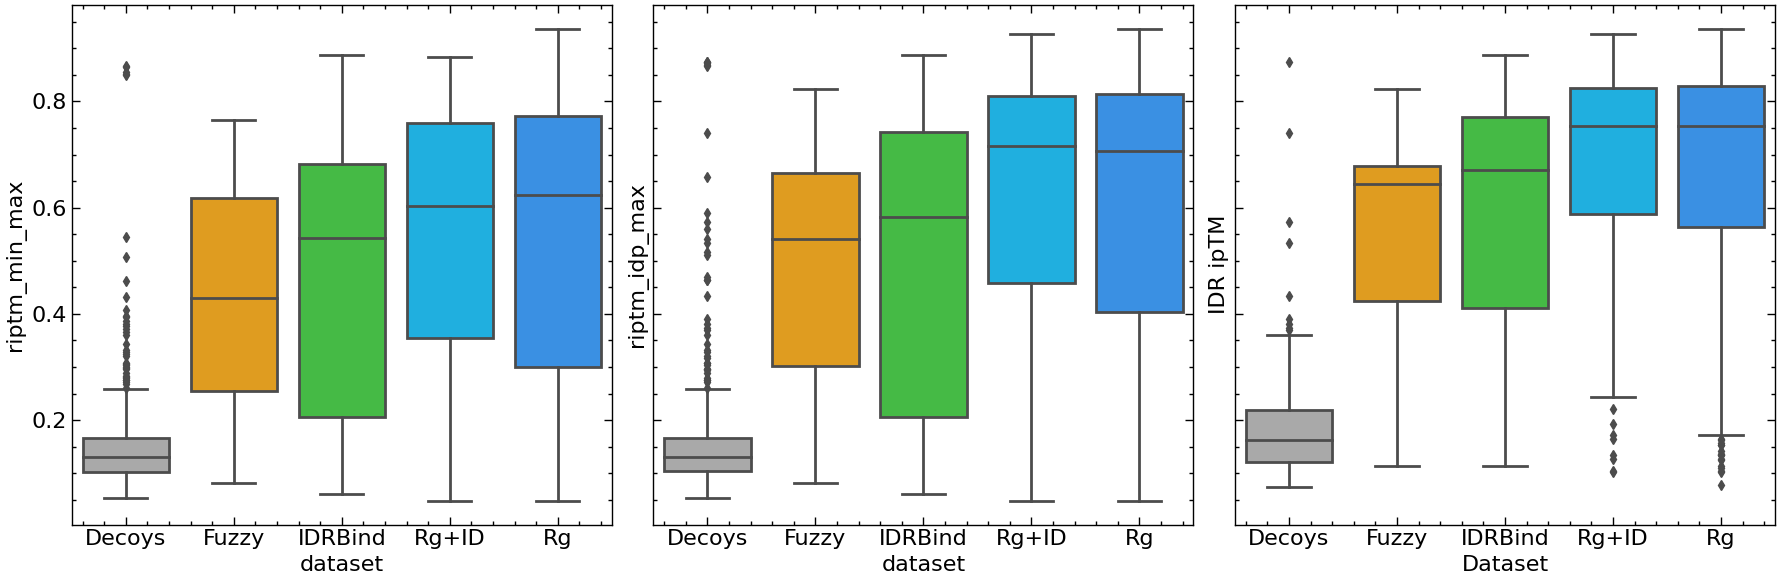

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg+ID', 'Rg']
colors = [DECOYS_DATASET_COLOR, FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RGID_DATASET_COLOR, RG_DATASET_COLOR]

df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
# df_tmp.loc[df_tmp['dataset'] == 'Decoys', 'capri'] = 'Incorrect'
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.boxplot(data=df_tmp, x='dataset', y='riptm_min_max', order=order, palette=colors, ax=ax[0])

df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
# df_tmp.loc[df_tmp['dataset'] == 'Decoys', 'capri'] = 'Incorrect'
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.boxplot(data=df_tmp, x='dataset', y='riptm_idp_max', order=order, palette=colors, ax=ax[1])

df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) & (df_pred['seed_rank_riptm_receptor_max'] == 1)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
# df_tmp.loc[df_tmp['dataset'] == 'Decoys', 'capri'] = 'Incorrect'
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
g = sns.boxplot(data=df_tmp, x='dataset', y='riptm_idp_max', order=order, palette=colors, ax=ax[2])

g.set(xlabel='Dataset', ylabel='IDR ipTM')

pairs = [
    # ('Decoys', 'Fuzzy'),
    # ('Decoys', 'IDRBind'),
    # ('Decoys', 'Rg+ID'),
    # ('Decoys', 'Rg'),
    # ('Decoys', 'Bret et al.'),
    # ('Fuzzy', 'IDRBind'),
    # ('Fuzzy', 'Rg+ID'),
    # ('Fuzzy', 'Rg'),
    # ('Fuzzy', 'Bret et al.'),
    # ('IDRBind', 'Rg+ID'),
    # ('IDRBind', 'Rg'),
    # ('IDRBind', 'Bret et al.'),
    ('Rg+ID', 'Rg'),
    ('Rg+ID', 'Bret et al.'),
    ('Rg', 'Bret et al.'),
]

# annotator = Annotator(g, pairs, x='dataset', y='combined', verbose=2, data=df_tmp, order=order)
# annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', verbose=2, hide_non_significant=False)
# annotator.apply_and_annotate()

# g.axhline(1, ls='--', color='k', lw=0.7, alpha=0.5)

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()

(2485, 142)
Rg         1050
Rg+ID       525
IDRBind     365
Decoys      360
Fuzzy       185
Name: dataset, dtype: int64
(497, 142)
Rg         210
Rg+ID      105
IDRBind     73
Decoys      72
Fuzzy       37
Name: dataset, dtype: int64
(498, 142)
Rg         210
Rg+ID      105
IDRBind     74
Decoys      72
Fuzzy       37
Name: dataset, dtype: int64


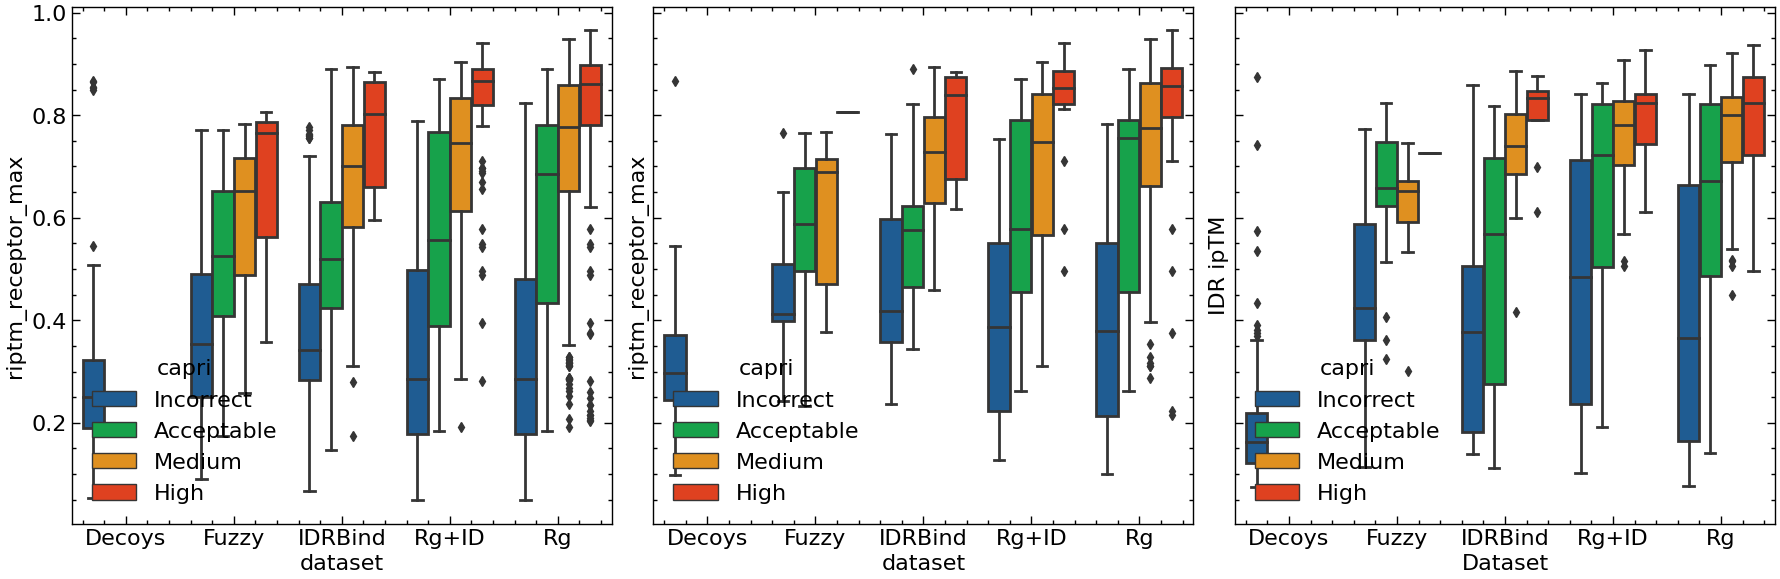

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg+ID', 'Rg']
colors = [DECOYS_DATASET_COLOR, FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RGID_DATASET_COLOR, RG_DATASET_COLOR]

df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
df_tmp.loc[df_tmp['dataset'] == 'Decoys', 'capri'] = 'Incorrect'
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.boxplot(data=df_tmp, x='dataset', y='riptm_receptor_max', order=order, hue='capri', hue_order=CAPRI_CLASSES, ax=ax[0])

df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) & (df_pred['seed_rank'] == 1)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
df_tmp.loc[df_tmp['dataset'] == 'Decoys', 'capri'] = 'Incorrect'
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.boxplot(data=df_tmp, x='dataset', y='riptm_receptor_max', order=order, hue='capri', hue_order=CAPRI_CLASSES, ax=ax[1])

df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) & (df_pred['seed_rank_riptm_receptor_max'] == 1)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
df_tmp.loc[df_tmp['dataset'] == 'Decoys', 'capri'] = 'Incorrect'
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
g = sns.boxplot(data=df_tmp, x='dataset', y='riptm_idp_max', order=order, hue='capri', hue_order=CAPRI_CLASSES, ax=ax[2])

g.set(xlabel='Dataset', ylabel='IDR ipTM')

pairs = [
    # ('Decoys', 'Fuzzy'),
    # ('Decoys', 'IDRBind'),
    # ('Decoys', 'Rg+ID'),
    # ('Decoys', 'Rg'),
    # ('Decoys', 'Bret et al.'),
    # ('Fuzzy', 'IDRBind'),
    # ('Fuzzy', 'Rg+ID'),
    # ('Fuzzy', 'Rg'),
    # ('Fuzzy', 'Bret et al.'),
    # ('IDRBind', 'Rg+ID'),
    # ('IDRBind', 'Rg'),
    # ('IDRBind', 'Bret et al.'),
    ('Rg+ID', 'Rg'),
    ('Rg+ID', 'Bret et al.'),
    ('Rg', 'Bret et al.'),
]

# annotator = Annotator(g, pairs, x='dataset', y='combined', verbose=2, data=df_tmp, order=order)
# annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', verbose=2, hide_non_significant=False)
# annotator.apply_and_annotate()

# g.axhline(1, ls='--', color='k', lw=0.7, alpha=0.5)

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()

(2485, 142)
Rg         1050
Rg+ID       525
IDRBind     365
Decoys      360
Fuzzy       185
Name: dataset, dtype: int64
(497, 142)
Rg         210
Rg+ID      105
IDRBind     73
Decoys      72
Fuzzy       37
Name: dataset, dtype: int64
(497, 142)
Rg         210
Rg+ID      105
IDRBind     73
Decoys      72
Fuzzy       37
Name: dataset, dtype: int64


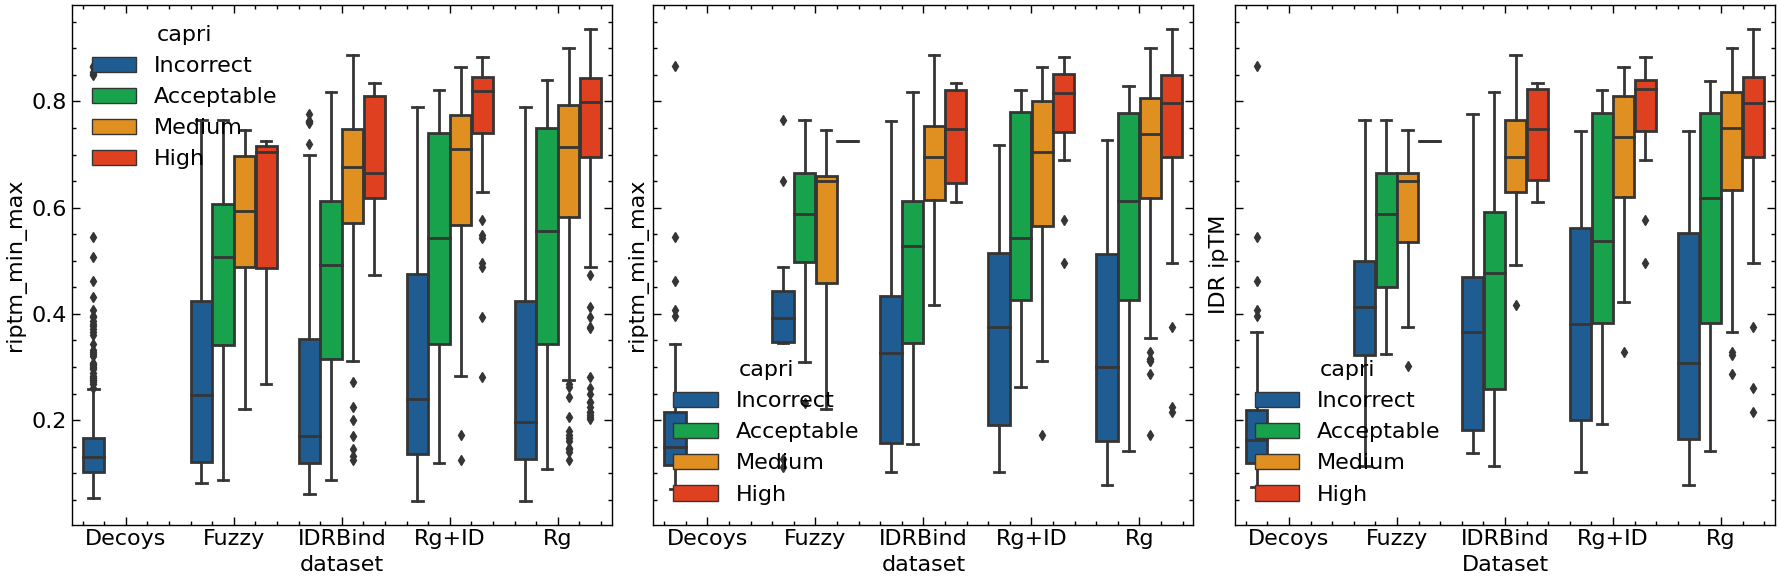

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg+ID', 'Rg']
colors = [DECOYS_DATASET_COLOR, FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RGID_DATASET_COLOR, RG_DATASET_COLOR]

df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
df_tmp.loc[df_tmp['dataset'] == 'Decoys', 'capri'] = 'Incorrect'
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.boxplot(data=df_tmp, x='dataset', y='riptm_min_max', order=order, hue='capri', hue_order=CAPRI_CLASSES, ax=ax[0])

df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) & (df_pred['seed_rank'] == 1)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
df_tmp.loc[df_tmp['dataset'] == 'Decoys', 'capri'] = 'Incorrect'
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.boxplot(data=df_tmp, x='dataset', y='riptm_min_max', order=order, hue='capri', hue_order=CAPRI_CLASSES, ax=ax[1])

df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) & (df_pred['seed_rank_riptm_min_max'] == 1)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
df_tmp.loc[df_tmp['dataset'] == 'Decoys', 'capri'] = 'Incorrect'
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
g = sns.boxplot(data=df_tmp, x='dataset', y='riptm_min_max', order=order, hue='capri', hue_order=CAPRI_CLASSES, ax=ax[2])

g.set(xlabel='Dataset', ylabel='IDR ipTM')

pairs = [
    # ('Decoys', 'Fuzzy'),
    # ('Decoys', 'IDRBind'),
    # ('Decoys', 'Rg+ID'),
    # ('Decoys', 'Rg'),
    # ('Decoys', 'Bret et al.'),
    # ('Fuzzy', 'IDRBind'),
    # ('Fuzzy', 'Rg+ID'),
    # ('Fuzzy', 'Rg'),
    # ('Fuzzy', 'Bret et al.'),
    # ('IDRBind', 'Rg+ID'),
    # ('IDRBind', 'Rg'),
    # ('IDRBind', 'Bret et al.'),
    ('Rg+ID', 'Rg'),
    ('Rg+ID', 'Bret et al.'),
    ('Rg', 'Bret et al.'),
]

# annotator = Annotator(g, pairs, x='dataset', y='combined', verbose=2, data=df_tmp, order=order)
# annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', verbose=2, hide_non_significant=False)
# annotator.apply_and_annotate()

# g.axhline(1, ls='--', color='k', lw=0.7, alpha=0.5)

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()

In [66]:
df_tmp2 = df_tmp.explode('riptm_receptor')
print(df_tmp2.shape)
print(df_tmp2['dataset'].value_counts())

(166399, 142)
Rg         79440
Rg+ID      40074
Decoys     27305
IDRBind    15117
Fuzzy       4463
Name: dataset, dtype: int64


(2125, 142)
Rg         1050
Rg+ID       525
IDRBind     365
Fuzzy       185
Name: dataset, dtype: int64


/tmp/ipykernel_360512/782248935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.fillna({


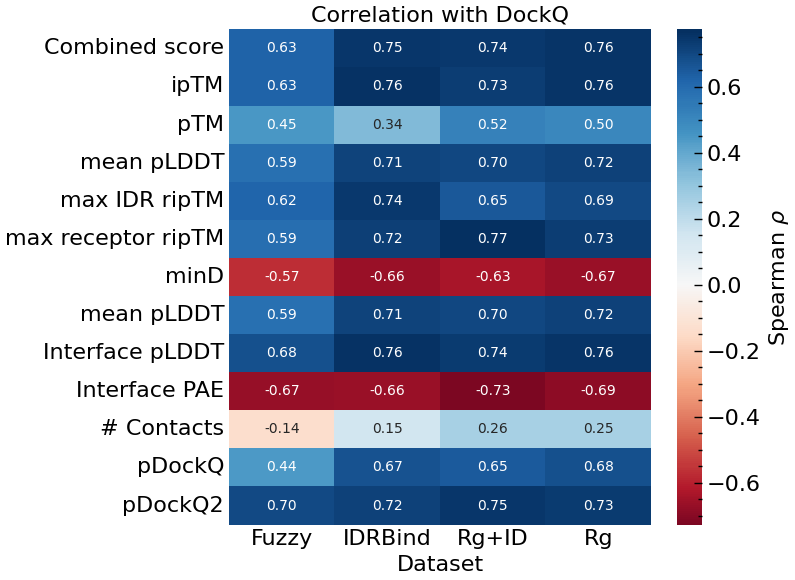

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))
order = ['Fuzzy', 'IDRBind', 'Rg+ID', 'Rg']
pals = [CAPRI_COLORS_FUZZY, CAPRI_COLORS_IDRBIND, CAPRI_COLORS_RGID, CAPRI_COLORS_RG]
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) &
                 (df_pred['reference_model'] == 1) & (df_pred['dataset'].isin(order))]
df_tmp.fillna({
    'plddt_iface_mean': 0,
    'pae_iface_mean': 31.75,
    'n_contacts': 0,
    'pdockq_elof': 0,
    'pdockq2_elof': 0
}, inplace=True)
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())

# per dataset heatmapt correlation of combined, iptm, ptm, plddtwith DockQ
df_corr = df_tmp.groupby('dataset')[
    ['combined', 'iptm', 'ptm', 'plddt_idp_mean',
    'riptm_idp_max', 'riptm_receptor_max',
    'distogram_idp_min', 'plddt_idp_mean',
    'plddt_iface_mean', 'pae_iface_mean', 'n_contacts', 'pdockq_elof', 'pdockq2_elof']
].corrwith(df_tmp['dockq'], method='spearman')
df_corr = df_corr.reset_index()
df_corr.set_index('dataset', inplace=True)
df_corr = df_corr.loc[order]
df_corr.rename(columns={'combined': 'Combined score', 'iptm': 'ipTM', 'ptm': 'pTM', 'plddt_idp_mean': 'IDR pLDDT',
            'riptm_idp_mean': 'mean IDR ripTM', 'riptm_idp_max': 'max IDR ripTM', 'riptm_receptor_max': 'max receptor ripTM',
            'distogram_idp_min': 'minD', 'plddt_idp_mean': 'mean pLDDT', 'plddt_iface_mean': 'Interface pLDDT',
            'pae_iface_mean': 'Interface PAE', 'n_contacts': '# Contacts', 'pdockq_elof': 'pDockQ', 'pdockq2_elof': 'pDockQ2'}, inplace=True)
g = sns.heatmap(df_corr.T, cmap='RdBu', annot=True, fmt='.2f', cbar_kws={'label': r'Spearman $\rho$'}, ax=ax, center=0)
g.set_title('Correlation with DockQ')
g.set(ylabel='', xlabel='Dataset')
g.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
fig.savefig('../figures/corr_heatmap.pdf', bbox_inches='tight')

(2125, 142)
Rg         1050
Rg+ID       525
IDRBind     365
Fuzzy       185
Name: dataset, dtype: int64


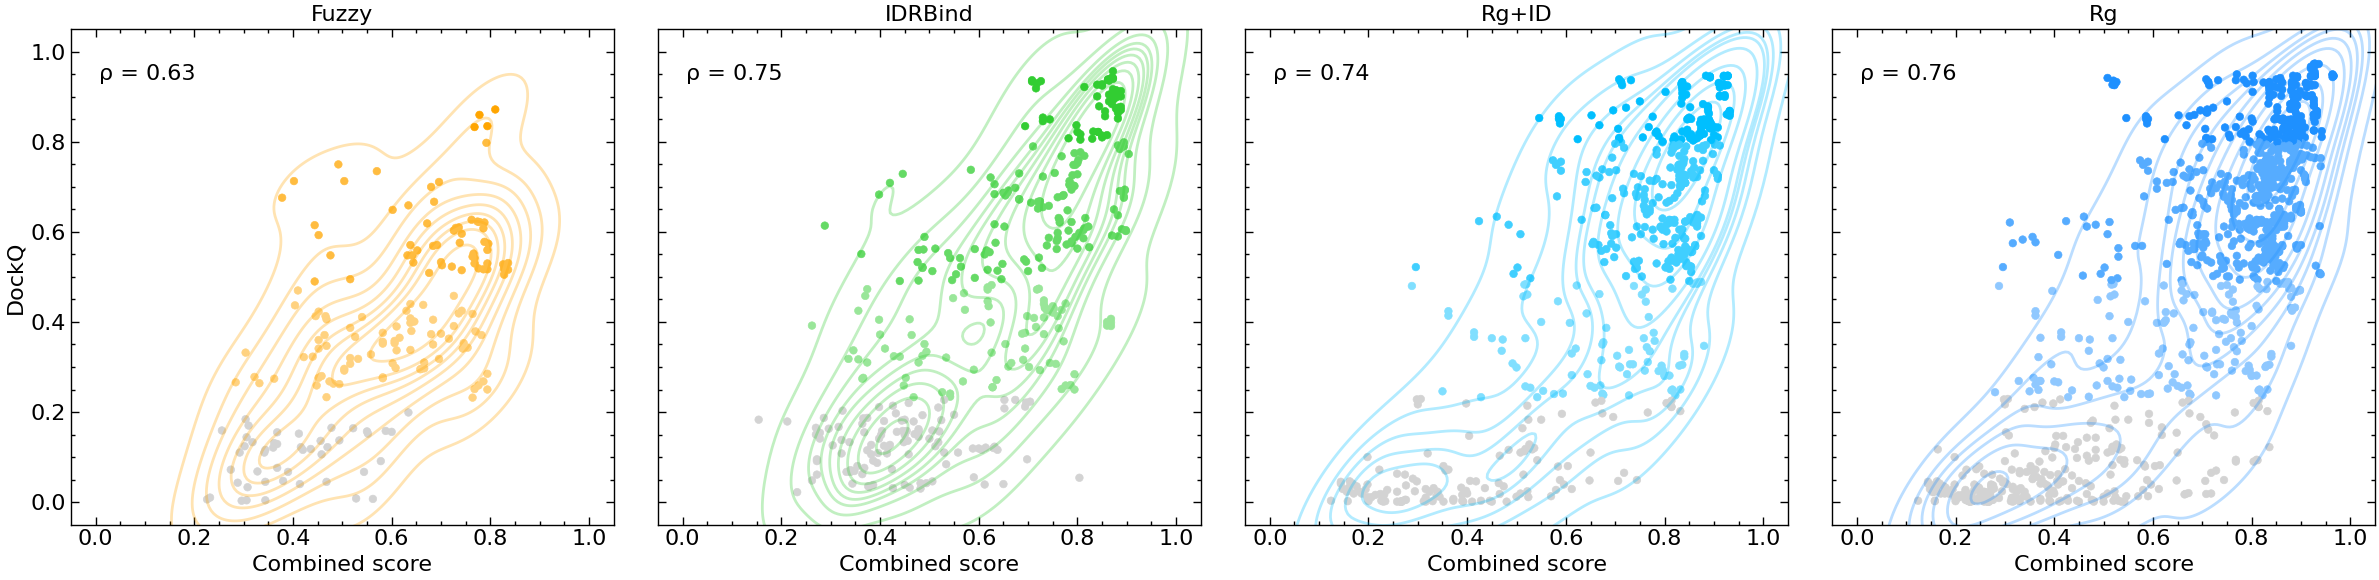

In [69]:
fig, ax = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
order = ['Fuzzy', 'IDRBind', 'Rg+ID', 'Rg']#, 'Bret et al.']
pals = [CAPRI_COLORS_FUZZY, CAPRI_COLORS_IDRBIND, CAPRI_COLORS_RGID, CAPRI_COLORS_RG, CAPRI_COLORS_SCANIDR]
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) &
                 (df_pred['reference_model'] == 1) & (df_pred['dataset'].isin(order))]
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
for i, (dataset, pal) in enumerate(zip(order, pals)):
    g = sns.scatterplot(data=df_tmp[df_tmp['dataset'] == dataset], x='combined', y='dockq', hue='capri_dockq', hue_order=CAPRI_CLASSES,
                        palette=pal, s=30, edgecolor=None, ax=ax[i])
    g = sns.kdeplot(data=df_tmp[df_tmp['dataset'] == dataset], x='combined', y='dockq', fill=False, ax=ax[i], color=pal[-1], alpha=0.3)
    pearson_r = df_tmp[df_tmp['dataset'] == dataset][['combined', 'dockq']].corr(method='spearman').iloc[0, 1]
    g.set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))
    # g.set_aspect('equal')
    g.set_xlabel('Combined score')
    g.set_ylabel('DockQ')
    g.set_title(dataset)
    g.legend(handles=[plt.Line2D([0], [0], alpha=0)], labels=[f'ρ = {pearson_r:.2f}'], loc='upper left')
    sns.move_legend(g, loc='upper left', bbox_to_anchor=(-0.1, 0.97))

plt.tight_layout()
fig.savefig('../figures/dockqcombinedscatter.pdf', bbox_inches='tight')

(2125, 142)
Rg         1050
Rg+ID       525
IDRBind     365
Fuzzy       185
Name: dataset, dtype: int64


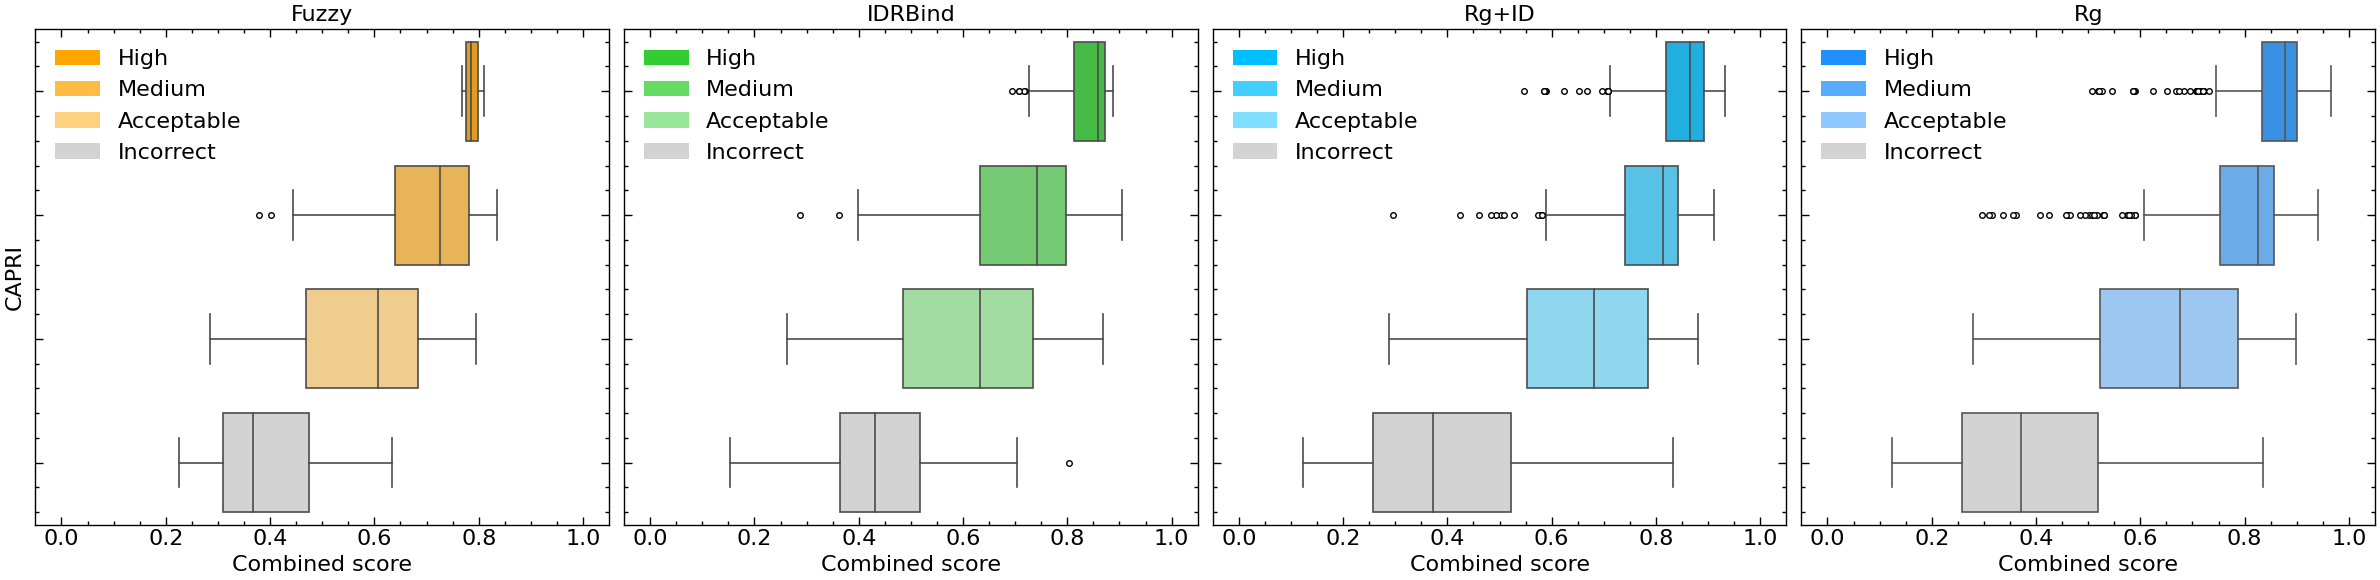

In [71]:
fig, ax = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
# order = ['Fuzzy', 'IDRBind', 'Rg+ID', 'Rg']
# pals = [CAPRI_COLORS_FUZZY, CAPRI_COLORS_IDRBIND, CAPRI_COLORS_RGID, CAPRI_COLORS_RG]
# df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) &
#                  (df_pred['reference_model'] == 1) & (df_pred['dataset'].isin(order))]
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
for i, (dataset, pal) in enumerate(zip(order, pals)):
    g = sns.boxplot(data=df_tmp[df_tmp['dataset'] == dataset], x='combined', y='capri_dockq', orient='h',
                 order=CAPRI_CLASSES[::-1], linewidth=1.2, ax=ax[i], palette=pal[::-1],
                 flierprops={'marker': 'o', 'markerfacecolor': 'white', 'markeredgecolor': 'black', 'markersize': 4})
    g.set_xlim(-0.05, 1.05)
    g.set(xlabel='Combined score')
    if i == 0:
        g.set_ylabel('CAPRI')
    else:
        g.set_ylabel('')
    g.set_yticklabels([])
    g.set_title(dataset)
    g.legend(
        handles=[Patch(facecolor=pal[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
        labels=CAPRI_CLASSES[::-1], loc='upper left', title='', ncol=1
    )

plt.tight_layout()
fig.savefig('../figures/dockqcombinedbox.pdf', bbox_inches='tight')

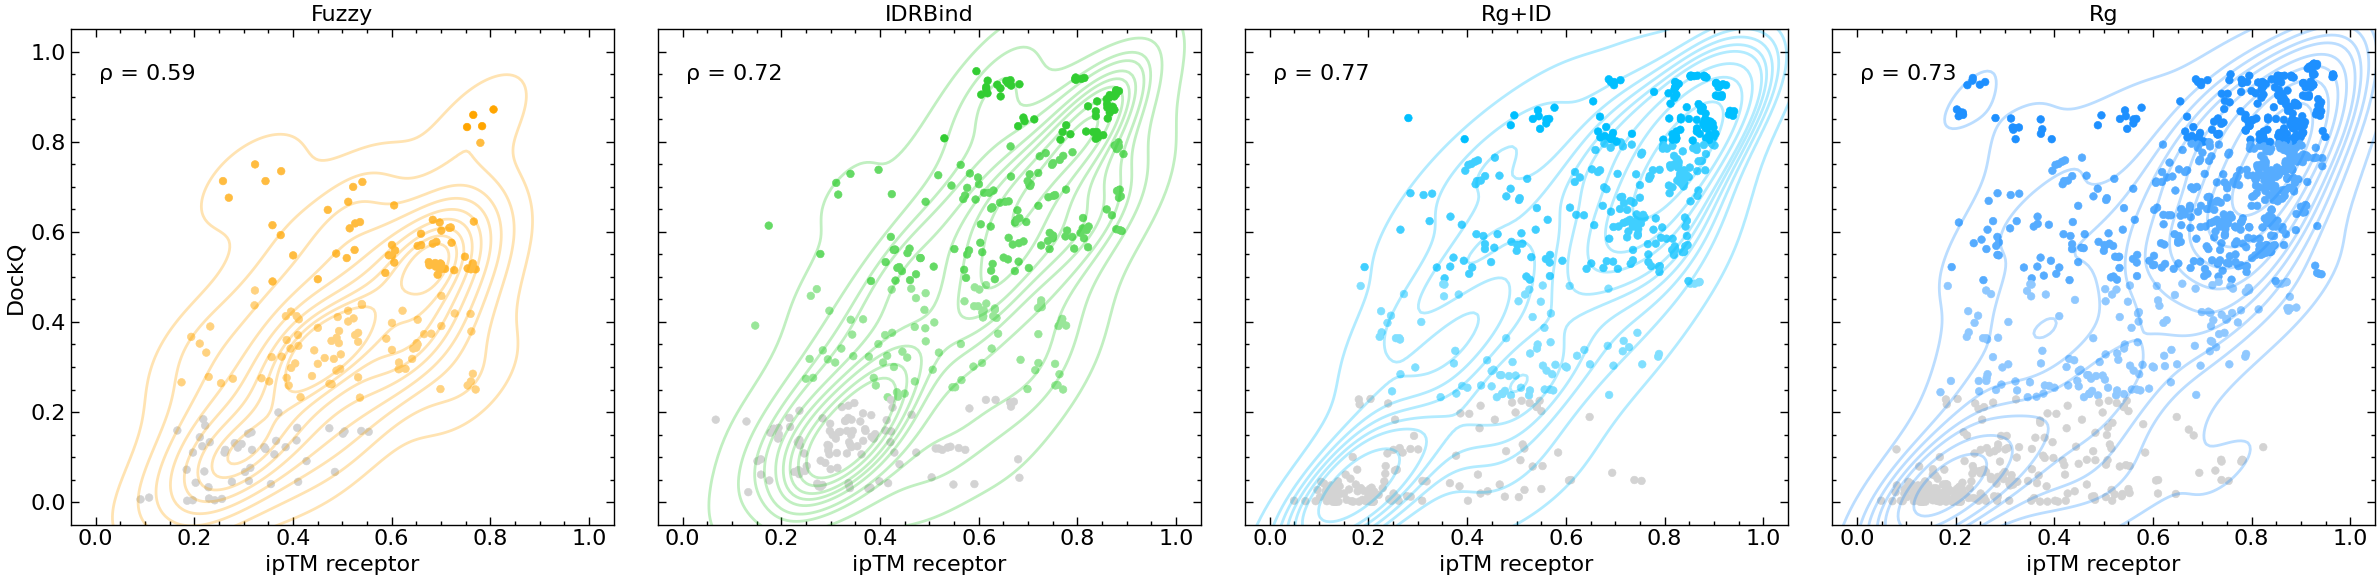

In [73]:
fig, ax = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
for i, (dataset, pal) in enumerate(zip(order, pals)):
    g = sns.scatterplot(data=df_tmp[df_tmp['dataset'] == dataset], x='riptm_receptor_max', y='dockq', hue='capri_dockq', hue_order=CAPRI_CLASSES,
                        palette=pal, s=30, edgecolor=None, ax=ax[i])
    g = sns.kdeplot(data=df_tmp[df_tmp['dataset'] == dataset], x='riptm_receptor_max', y='dockq', fill=False, ax=ax[i], color=pal[-1], alpha=0.3)
    pearson_r = df_tmp[df_tmp['dataset'] == dataset][['riptm_receptor_max', 'dockq']].corr(method='spearman').iloc[0, 1]
    g.set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))
    # g.set_aspect('equal')
    g.set_xlabel('ipTM receptor')
    g.set_ylabel('DockQ')
    g.set_title(dataset)
    g.legend(handles=[plt.Line2D([0], [0], alpha=0)], labels=[f'ρ = {pearson_r:.2f}'], loc='upper left')
    sns.move_legend(g, loc='upper left', bbox_to_anchor=(-0.1, 0.97))

plt.tight_layout()

(2125, 142)
Rg         1050
Rg+ID       525
IDRBind     365
Fuzzy       185
Name: dataset, dtype: int64


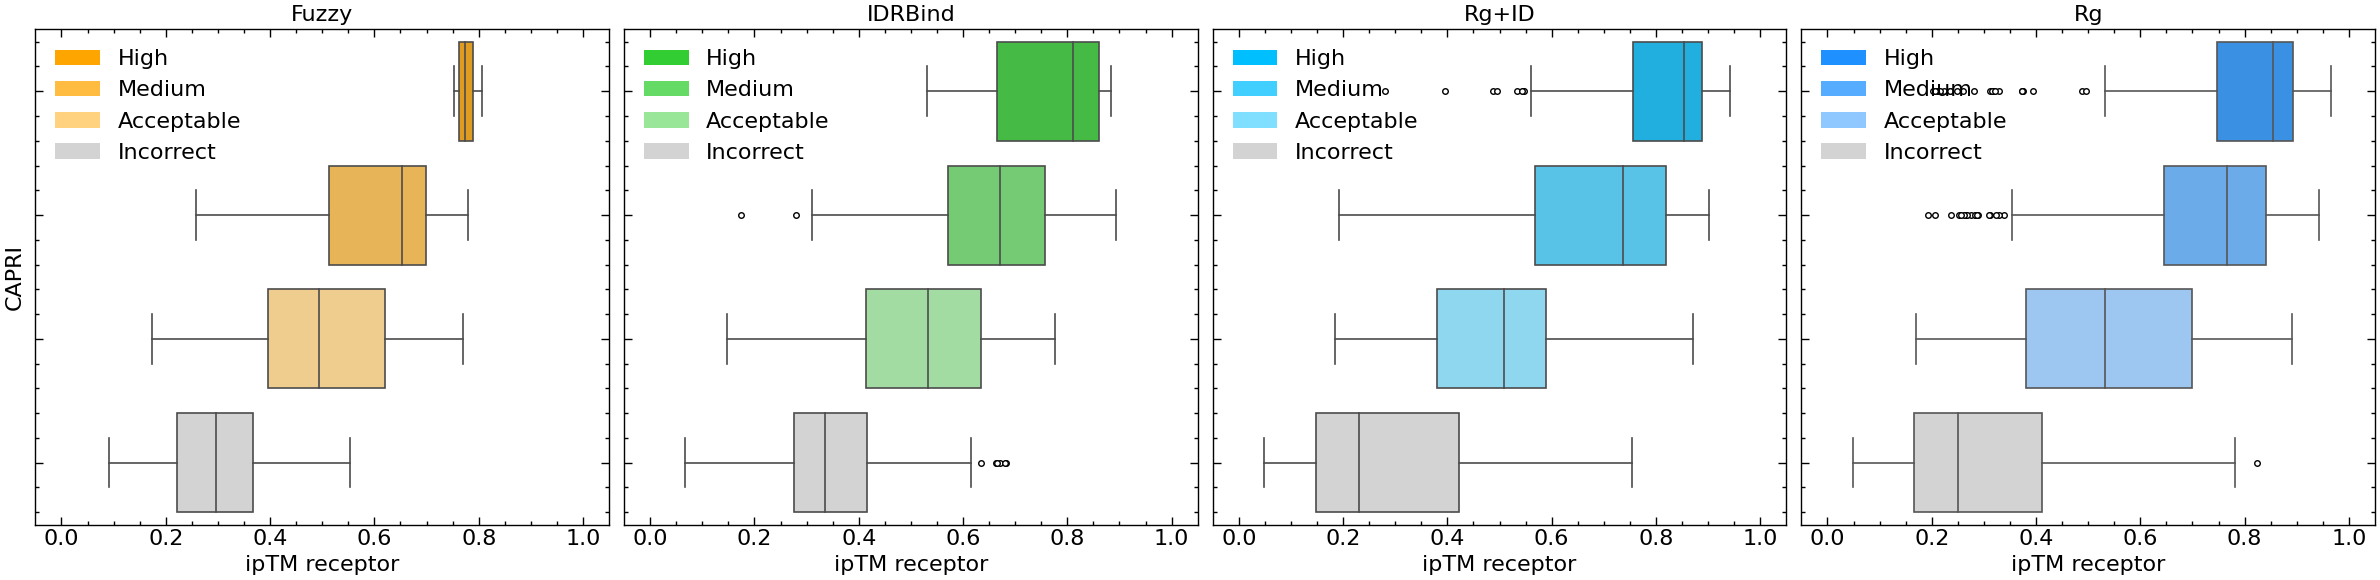

In [74]:
fig, ax = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
# order = ['Fuzzy', 'IDRBind', 'Rg+ID', 'Rg']
# pals = [CAPRI_COLORS_FUZZY, CAPRI_COLORS_IDRBIND, CAPRI_COLORS_RGID, CAPRI_COLORS_RG]
# df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) &
#                  (df_pred['reference_model'] == 1) & (df_pred['dataset'].isin(order))]
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
for i, (dataset, pal) in enumerate(zip(order, pals)):
    g = sns.boxplot(data=df_tmp[df_tmp['dataset'] == dataset], x='riptm_receptor_max', y='capri_dockq', orient='h',
                 order=CAPRI_CLASSES[::-1], linewidth=1.2, ax=ax[i], palette=pal[::-1],
                 flierprops={'marker': 'o', 'markerfacecolor': 'white', 'markeredgecolor': 'black', 'markersize': 4})
    g.set_xlim(-0.05, 1.05)
    g.set(xlabel='ipTM receptor')
    if i == 0:
        g.set_ylabel('CAPRI')
    else:
        g.set_ylabel('')
    g.set_yticklabels([])
    g.set_title(dataset)
    g.legend(
        handles=[Patch(facecolor=pal[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
        labels=CAPRI_CLASSES[::-1], loc='upper left', title='', ncol=1
    )

plt.tight_layout()

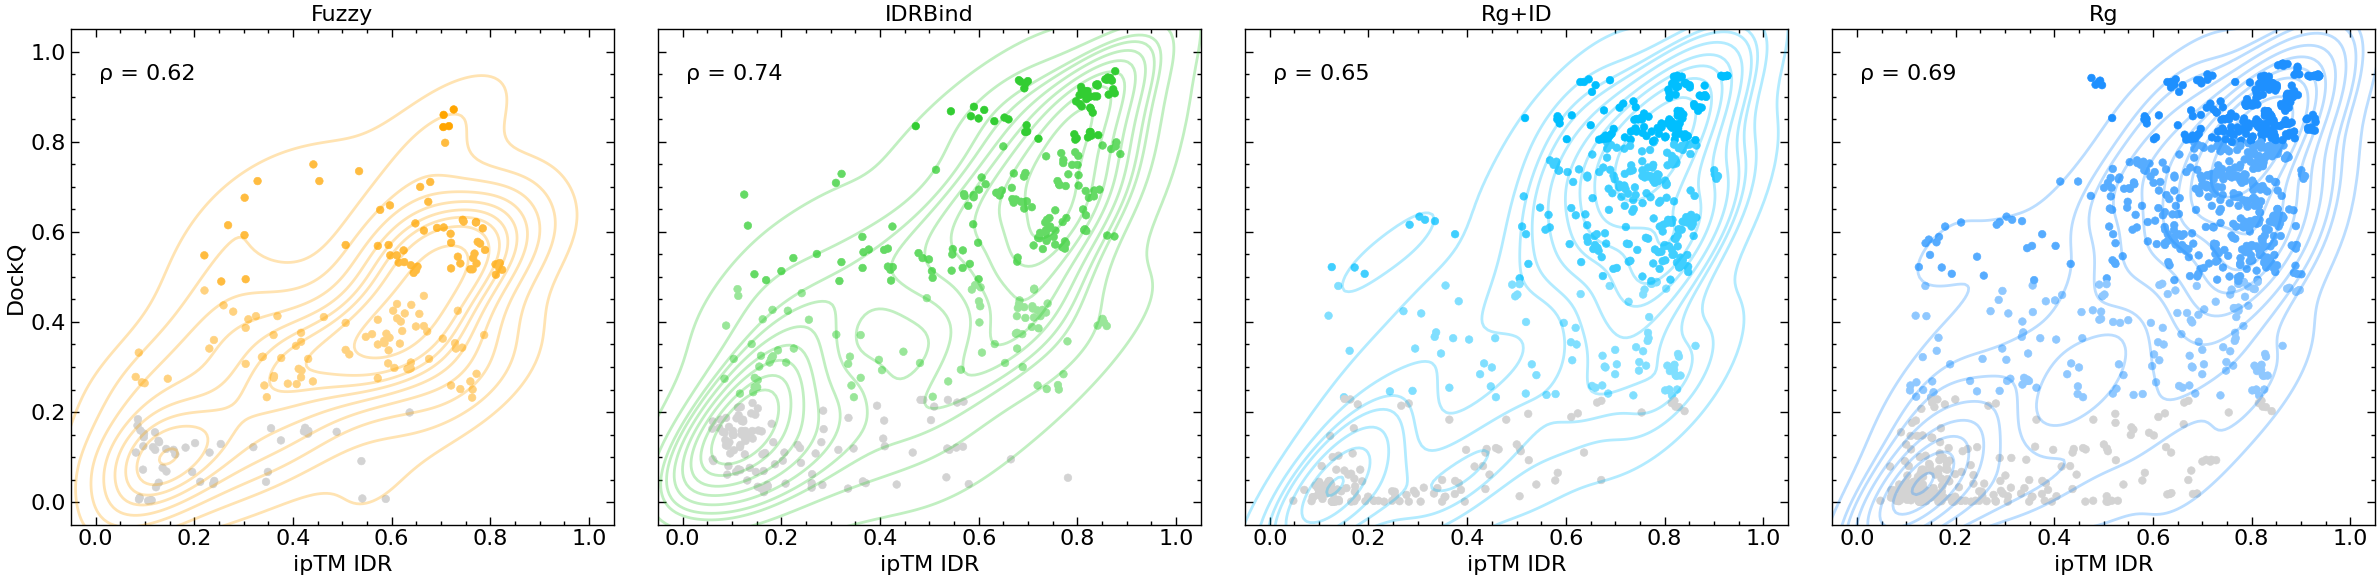

In [76]:
fig, ax = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
for i, (dataset, pal) in enumerate(zip(order, pals)):
    g = sns.scatterplot(data=df_tmp[df_tmp['dataset'] == dataset], x='riptm_idp_max', y='dockq', hue='capri_dockq', hue_order=CAPRI_CLASSES,
                        palette=pal, s=30, edgecolor=None, ax=ax[i])
    g = sns.kdeplot(data=df_tmp[df_tmp['dataset'] == dataset], x='riptm_idp_max', y='dockq', fill=False, ax=ax[i], color=pal[-1], alpha=0.3)
    pearson_r = df_tmp[df_tmp['dataset'] == dataset][['riptm_idp_max', 'dockq']].corr(method='spearman').iloc[0, 1]
    g.set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))
    # g.set_aspect('equal')
    g.set_xlabel('ipTM IDR')
    g.set_ylabel('DockQ')
    g.set_title(dataset)
    g.legend(handles=[plt.Line2D([0], [0], alpha=0)], labels=[f'ρ = {pearson_r:.2f}'], loc='upper left')
    sns.move_legend(g, loc='upper left', bbox_to_anchor=(-0.1, 0.97))

plt.tight_layout()

(2125, 142)
Rg         1050
Rg+ID       525
IDRBind     365
Fuzzy       185
Name: dataset, dtype: int64


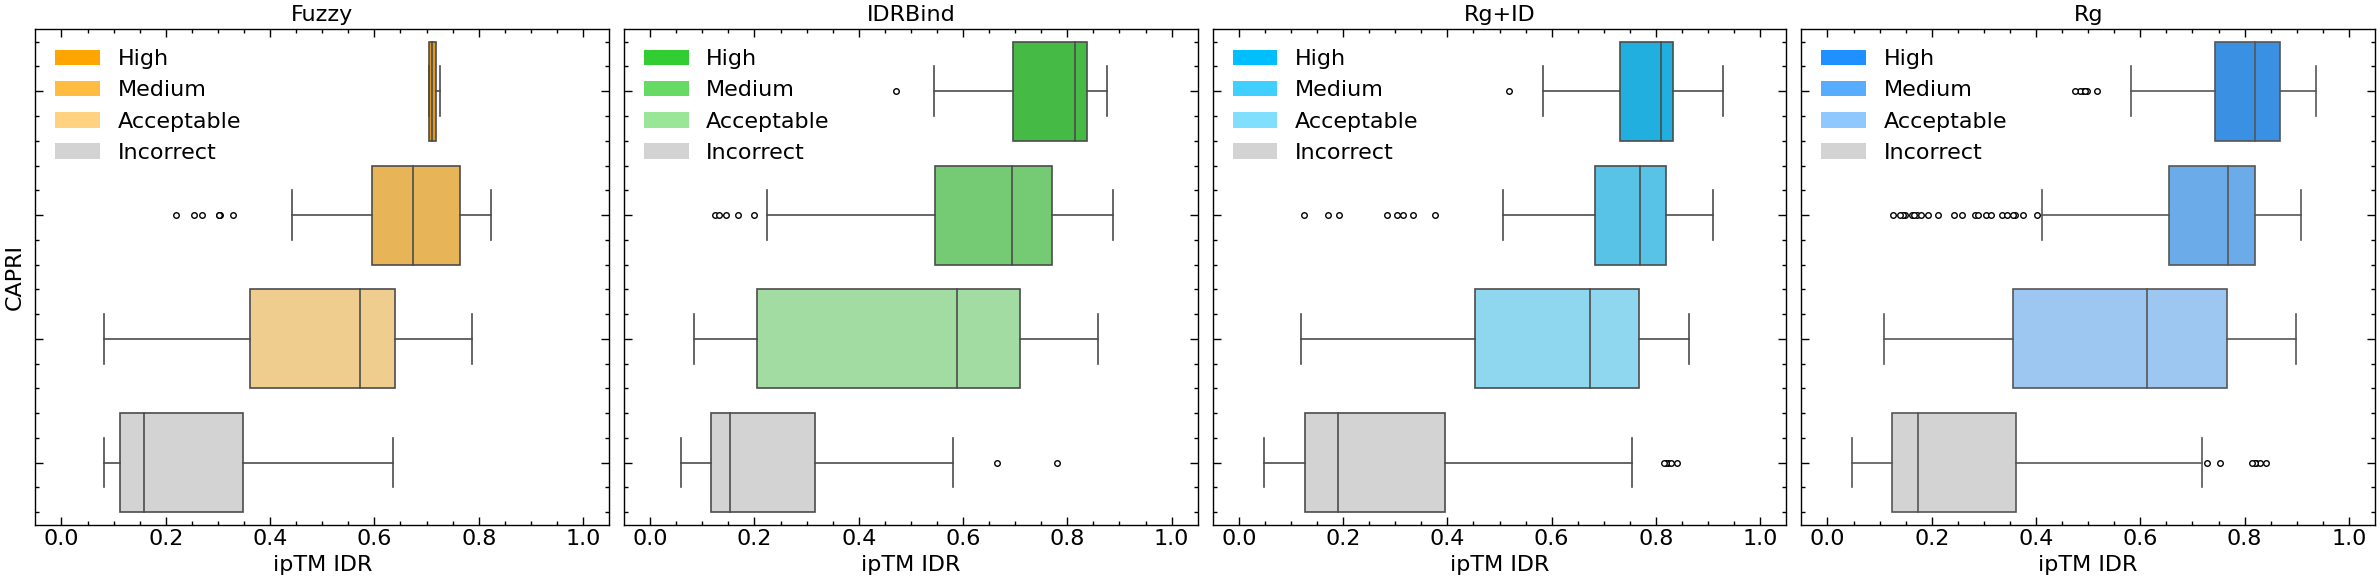

In [77]:
fig, ax = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
# order = ['Fuzzy', 'IDRBind', 'Rg+ID', 'Rg']
# pals = [CAPRI_COLORS_FUZZY, CAPRI_COLORS_IDRBIND, CAPRI_COLORS_RGID, CAPRI_COLORS_RG]
# df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) &
#                  (df_pred['reference_model'] == 1) & (df_pred['dataset'].isin(order))]
print(df_tmp.shape)
print(df_tmp['dataset'].value_counts())
for i, (dataset, pal) in enumerate(zip(order, pals)):
    g = sns.boxplot(data=df_tmp[df_tmp['dataset'] == dataset], x='riptm_idp_max', y='capri_dockq', orient='h',
                 order=CAPRI_CLASSES[::-1], linewidth=1.2, ax=ax[i], palette=pal[::-1],
                 flierprops={'marker': 'o', 'markerfacecolor': 'white', 'markeredgecolor': 'black', 'markersize': 4})
    g.set_xlim(-0.05, 1.05)
    g.set(xlabel='ipTM IDR')
    if i == 0:
        g.set_ylabel('CAPRI')
    else:
        g.set_ylabel('')
    g.set_yticklabels([])
    g.set_title(dataset)
    g.legend(
        handles=[Patch(facecolor=pal[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
        labels=CAPRI_CLASSES[::-1], loc='upper left', title='', ncol=1
    )

plt.tight_layout()

---

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

df_tmp = df[(df['exp'].isin(['delim_idp_recycles'])) & (df['recycle'].isna()) & (df['seed'] == 0)]
g = sns.boxplot(data=df_tmp, x='combined', y='capri', orient='h', palette=CAPRI_COLORS_IDRBIND[::-1],
                 order=CAPRI_CLASSES[::-1], linewidth=1.2, ax=ax,
                 flierprops={'marker': 'o', 'markerfacecolor': 'white', 'markeredgecolor': 'black', 'markersize': 4})
g.set_xlim(-0.01, 1.01)

pairs = [
    ['Incorrect', 'Acceptable'],
    # ['Incorrect', 'Medium'],
    # ['Incorrect', 'High'],
    ['Medium', 'High'],
    ['Acceptable', 'Medium'],
    # ['Acceptable', 'High'],
]

annotator = Annotator(g, pairs, data=df_tmp, x='combined', y='capri', order=CAPRI_CLASSES[::-1],
                      orient='h')
annotator.configure(test='Mann-Whitney-gt', text_format='star', verbose=2, loc='outside')
annotator.apply_and_annotate()

g.set_ylabel('')
g.set_xlabel('Combined score')
g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
plt.legend(
    handles=[Patch(facecolor=CAPRI_COLORS_IDRBIND[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
    labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
)

plt.tight_layout()

fig.savefig('../figures/combinedboxplot_idrbind.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)]
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg', 'Bret et al.']
colors = ['Grey', FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.violinplot(data=df_tmp, x='dataset', y='combined', ax=ax, order=order, palette=colors, showfliers=False)
g.set(xlabel=' ', ylabel='Combined score')
# sns.despine()

pairs = [
    ['Fuzzy', 'IDRBind'],
    # ['Rg', 'Bret et al.'],
    # ['IDRBind', 'Rg'],
    ['Fuzzy', 'Bret et al.'],
    ['Fuzzy', 'Rg'],
    ['Decoys', 'Fuzzy'],
    ['Decoys', 'Rg'],
    ['Decoys', 'IDRBind'],
    # ['IDRBind', 'Bret et al.']
]

annotator = Annotator(g, pairs, x='dataset', y='combined', verbose=2, data=df_tmp, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annotator.apply_and_annotate()

# g.axhline(1, ls='--', color='k', lw=0.7, alpha=0.5)

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()
# fig.savefig('../figures/dockqfuzzyvsrg.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)]
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg', 'Bret et al.']
colors = ['Grey', FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.violinplot(data=df_tmp, x='dataset', y='ptm', ax=ax, order=order, palette=colors, showfliers=False)
g.set(xlabel=' ', ylabel='Combined score')
# sns.despine()

pairs = [
    ['Fuzzy', 'IDRBind'],
    # ['Rg', 'Bret et al.'],
    # ['IDRBind', 'Rg'],
    ['Fuzzy', 'Bret et al.'],
    ['Fuzzy', 'Rg'],
    ['Decoys', 'Fuzzy'],
    ['Decoys', 'Rg'],
    ['Decoys', 'IDRBind'],
    # ['IDRBind', 'Bret et al.']
]

annotator = Annotator(g, pairs, x='dataset', y='ptm', verbose=2, data=df_tmp, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annotator.apply_and_annotate()

# g.axhline(1, ls='--', color='k', lw=0.7, alpha=0.5)

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()
# fig.savefig('../figures/dockqfuzzyvsrg.pdf', bbox_inches='tight')

In [ ]:
df_tmp[df_tmp['plddt_idp_mean'].isna()].value_counts('dataset')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)]
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg']
colors = ['Grey', FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.violinplot(data=df_tmp, x='dataset', y='plddt_idp_mean', ax=ax, order=order, palette=colors, showfliers=False)
g.set(xlabel=' ', ylabel='Combined score')
# sns.despine()

pairs = [
    ['Fuzzy', 'IDRBind'],
    # ['Rg', 'Bret et al.'],
    # ['IDRBind', 'Rg'],
    # ['Fuzzy', 'Bret et al.'],
    ['Fuzzy', 'Rg'],
    ['Decoys', 'Fuzzy'],
    ['Decoys', 'Rg'],
    ['Decoys', 'IDRBind'],
    # ['IDRBind', 'Bret et al.']
]

annotator = Annotator(g, pairs, x='dataset', y='plddt_idp_mean', verbose=2, data=df_tmp, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annotator.apply_and_annotate()

# g.axhline(1, ls='--', color='k', lw=0.7, alpha=0.5)

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()
# fig.savefig('../figures/dockqfuzzyvsrg.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') &
                 (df_pred['seed'] == 0) & (df_pred['capri'].isna() | (df_pred['dockq'] < 0.23))]
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg']
colors = ['Grey', FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.violinplot(data=df_tmp, x='dataset', y='plddt_idp_mean', ax=ax, order=order, palette=colors, showfliers=False)
g.set(xlabel=' ', ylabel='Combined score')
# sns.despine()

pairs = [
    ['Fuzzy', 'IDRBind'],
    # ['Rg', 'Bret et al.'],
    # ['IDRBind', 'Rg'],
    # ['Fuzzy', 'Bret et al.'],
    ['Fuzzy', 'Rg'],
    ['Decoys', 'Fuzzy'],
    ['Decoys', 'Rg'],
    ['Decoys', 'IDRBind'],
    # ['IDRBind', 'Bret et al.']
]

annotator = Annotator(g, pairs, x='dataset', y='plddt_idp_mean', verbose=2, data=df_tmp, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annotator.apply_and_annotate()

# g.axhline(1, ls='--', color='k', lw=0.7, alpha=0.5)

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()
# fig.savefig('../figures/dockqfuzzyvsrg.pdf', bbox_inches='tight')

In [ ]:
df_tmp = df_pred[(df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) & (df_pred['recycle'].isna())]
df_tmp = df_tmp[df_tmp['dataset'] == 'Fuzzy']
sns.scatterplot(
    data=df_tmp,
    x='combined', y='dockq',
    # hue=df_tmp['irms'].apply(lambda x: 1/(1+np.exp(-(-x+5)))),
    # hue='capri', hue_order=CAPRI_CLASSES[::-1], palette=CAPRI_COLORS[::-1],
    alpha=0.8
)

# correlation
non_na = df_tmp[['combined', 'dockq']].dropna()
print(stats.spearmanr(non_na['combined'], non_na['dockq']))

In [1]:
order = ['Decoys', 'Fuzzy', 'IDRBind']
colors = ['Grey', FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR]
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) & (df_pred['seed_rank'] == 1)
                 & ((df_pred['reference_model'] == 1) | (df_pred['dataset'] == 'Decoys'))
                 & ((df_pred['capri_dockq'] != 'Incorrect') | (df_pred['dataset'] == 'Decoys'))
                 & (df_pred['dataset'].isin(order))]
df_tmp['pae_idp_mean'] = df_tmp['pae_receptor_idp_mean'].apply(lambda x: np.min(eval(x)))
x = 'combined'
y = 'pae_idp_mean'
g = sns.scatterplot(
    data=df_tmp,
    # x=x, y=y,
    x=x, y=np.log1p(df_tmp[y]),
    hue='dataset', palette=colors, hue_order=order,
    # hue='capri', hue_order=CAPRI_CLASSES[::-1], palette=CAPRI_COLORS[::-1],
    alpha=0.8, s=10
)
g.set(xlim=(-0.05, 1.05))
g = sns.kdeplot(
    data=df_tmp,
    # x=x, y=y,
    x=x, y=np.log1p(df_tmp[y]),
    fill=False, hue='dataset', palette=colors, hue_order=order,
    levels=3,
    alpha=0.5
)

NameError: name 'FUZZY_DATASET_COLOR' is not defined

In [ ]:
df_tmp = df_pred[(df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) & (df_pred['recycle'].isna())]
df_tmp = df_tmp[df_tmp['dataset'] == 'Fuzzy']
sns.scatterplot(
    data=df_tmp,
    x='plddt_idp_mean', y='combined',
    # hue=df_tmp['irms'].apply(lambda x: 1/(1+np.exp(-(-x+5)))),
    hue='dockq',
    # hue='capri', hue_order=CAPRI_CLASSES[::-1], palette=CAPRI_COLORS[::-1],
    alpha=0.8
)

In [ ]:
df_tmp = df_pred[(df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) & (df_pred['recycle'].isna())]
df_tmp = df_tmp[df_tmp['dataset'] == 'IDRBind']
sns.scatterplot(
    data=df_tmp,
    x='plddt_idp_mean', y='combined',
    # hue=df_tmp['irms'].apply(lambda x: 1/(1+np.exp(-(-x+5)))),
    hue='dockq',
    # hue='capri', hue_order=CAPRI_CLASSES[::-1], palette=CAPRI_COLORS[::-1],
    alpha=0.8
)

In [ ]:
df_tmp = df_pred[(df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) & (df_pred['recycle'].isna())]
df_tmp = df_tmp[df_tmp['dataset'] == 'Rg']
sns.scatterplot(
    data=df_tmp,
    x='plddt_idp_mean', y='combined',
    # hue=df_tmp['irms'].apply(lambda x: 1/(1+np.exp(-(-x+5)))),
    hue='dockq',
    # hue='capri', hue_order=CAPRI_CLASSES[::-1], palette=CAPRI_COLORS[::-1],
    alpha=0.8
)

In [ ]:
df_tmp[(df_tmp['plddt_idp_mean'] < 50 ) & (df_tmp['dataset'] == 'Fuzzy')][['pdb_id', 'idp_id', 'receptor_id', 'rank', 'combined', 'plddt_idp_mean', 'capri', 'dockq']]

In [ ]:
df_tmp[(df_tmp['combined'] < 0.2) & (df_tmp['dataset'] == 'Fuzzy')][['pdb_id', 'idp_id', 'receptor_id', 'rank', 'combined', 'plddt_idp_mean', 'capri', 'dockq']]

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)]
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg', 'Bret et al.']
colors = ['Grey', FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.violinplot(data=df_tmp, x='dataset', y='iptm', ax=ax, order=order, palette=colors, showfliers=False)
g.set(xlabel=' ', ylabel='Combined score')
# sns.despine()

pairs = [
    ['Fuzzy', 'IDRBind'],
    # ['Rg', 'Bret et al.'],
    # ['IDRBind', 'Rg'],
    ['Fuzzy', 'Bret et al.'],
    ['Fuzzy', 'Rg'],
    ['Decoys', 'Fuzzy'],
    ['Decoys', 'Rg'],
    ['Decoys', 'IDRBind'],
    # ['IDRBind', 'Bret et al.']
]

annotator = Annotator(g, pairs, x='dataset', y='iptm', verbose=2, data=df_tmp, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annotator.apply_and_annotate()

# g.axhline(1, ls='--', color='k', lw=0.7, alpha=0.5)

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()
# fig.savefig('../figures/dockqfuzzyvsrg.pdf', bbox_inches='tight')

In [ ]:
df_pred[(df_pred['pdb_id'] == '7XVA') & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) & (df_pred['recycle'].isna())][['pdb_id', 'idp_id', 'receptor_id', 'dataset', 'rank', 'combined', 'plddt_idp_mean', 'capri', 'dockq']]

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') &
                 (df_pred['seed'] == 0) & (df_pred['capri_notail'].isna() | (df_pred['capri_notail'] == 'Incorrect'))]
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg', 'Bret et al.']
colors = ['Grey', FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.violinplot(data=df_tmp, x='dataset', y='combined', ax=ax, order=order, palette=colors, showfliers=False)
g.set(xlabel=' ', ylabel='Combined score')
# sns.despine()

pairs = [
    (p1, p2) for i, p1 in enumerate(order) for p2 in order[i+1:]
]

annotator = Annotator(g, pairs, x='dataset', y='combined', verbose=2, data=df_tmp, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annotator.apply_and_annotate()

# g.axhline(1, ls='--', color='k', lw=0.7, alpha=0.5)

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()
# fig.savefig('../figures/dockqfuzzyvsrg.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') &
                 (df_pred['seed'] == 0) & (df_pred['capri_notail'].isna() | (df_pred['dockq_notail'] < 0.23))]
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg', 'Bret et al.']
colors = ['Grey', FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.violinplot(data=df_tmp, x='dataset', y='combined', ax=ax, order=order, palette=colors, showfliers=False)
g.set(xlabel=' ', ylabel='Combined score')
# sns.despine()

pairs = [
    (p1, p2) for i, p1 in enumerate(order) for p2 in order[i+1:]
]

annotator = Annotator(g, pairs, x='dataset', y='combined', verbose=2, data=df_tmp, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annotator.apply_and_annotate()

# g.axhline(1, ls='--', color='k', lw=0.7, alpha=0.5)

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()
# fig.savefig('../figures/dockqfuzzyvsrg.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') &
                 (df_pred['seed'] == 0) & (df_pred['capri_notail'].isna() | (df_pred['capri_notail'] == 'Incorrect'))]
order = ['Decoys', 'Fuzzy', 'IDRBind', 'Rg', 'Bret et al.']
colors = ['Grey', FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.violinplot(data=df_tmp, x='dataset', y='ptm', ax=ax, order=order, palette=colors, showfliers=False)
g.set(xlabel=' ', ylabel='Combined score')
# sns.despine()

pairs = [
    (p1, p2) for i, p1 in enumerate(order) for p2 in order[i+1:]
]

annotator = Annotator(g, pairs, x='dataset', y='ptm', verbose=2, data=df_tmp, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annotator.apply_and_annotate()

# g.axhline(1, ls='--', color='k', lw=0.7, alpha=0.5)

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()
# fig.savefig('../figures/dockqfuzzyvsrg.pdf', bbox_inches='tight')

In [ ]:
df_tmp[(df_tmp['dataset'] == 'Decoys') & (df_tmp['pdb_id'] == '5ONS')]

In [ ]:
df_tmp[df_tmp['dataset'] == 'Decoys']

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0)]
order = ['Fuzzy', 'IDRBind', 'Rg', 'Bret et al.']
colors = [FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR, RG_DATASET_COLOR, SCANIDR_DATASET_COLOR]
# g = sns.stripplot(data=df_tmp, x='dataset', y='dockq', ax=ax, alpha=0.5, s=2)
g = sns.boxplot(data=df_tmp, x='dataset', y='combined', ax=ax, order=order, hue='capri', hue_order=CAPRI_CLASSES, palette=CAPRI_COLORS, showfliers=False)
g.set(xlabel=' ', ylabel='Combined score')
# sns.despine()

pairs = [
    ['Fuzzy', 'IDRBind'],
    # ['Rg', 'Bret et al.'],
    # ['IDRBind', 'Rg'],
    ['Fuzzy', 'Bret et al.'],
    ['Fuzzy', 'Rg'],
    # ['IDRBind', 'Bret et al.']
]

# annotator = Annotator(g, pairs, x='dataset', y='dockq', verbose=2, data=df_tmp, order=order)
# annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', verbose=2)
# annotator.apply_and_annotate()

# g.axhline(1, ls='--', color='k', lw=0.7, alpha=0.5)

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()
# fig.savefig('../figures/dockqfuzzyvsrg.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
g = sns.boxplot(data=df_tmp, x='dataset', y='iptm', ax=ax, order=order, hue='capri', hue_order=CAPRI_CLASSES, palette=CAPRI_COLORS, showfliers=False)
g.set(xlabel=' ', ylabel='ipTM')
# sns.despine()

pairs = [
    ['Fuzzy', 'IDRBind'],
    # ['Rg', 'Bret et al.'],
    # ['IDRBind', 'Rg'],
    ['Fuzzy', 'Bret et al.'],
    ['Fuzzy', 'Rg'],
    # ['IDRBind', 'Bret et al.']
]

# annotator = Annotator(g, pairs, x='dataset', y='dockq', verbose=2, data=df_tmp, order=order)
# annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', verbose=2)
# annotator.apply_and_annotate()

# g.axhline(1, ls='--', color='k', lw=0.7, alpha=0.5)

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()
# fig.savefig('../figures/dockqfuzzyvsrg.pdf', bbox_inches='tight')

In [ ]:
sns.scatterplot(
    data=df_pred,
    x='combined',
    y='plddt_idp_mean',
    hue='dataset',
    s=10,
)
sns.kdeplot(
    data=df_pred,
    x='combined',
    y='plddt_idp_mean',
    hue='dataset',
    alpha=0.8,
    levels=[0.3, 0.5, 0.9, 0.95, 0.99],
    common_norm=False,
)

In [ ]:
df_tmp = df_pred[(df_pred['recycle'].isna()) & (df_pred['exp'] == 'delim_idp') & (df_pred['seed'] == 0) & (df_pred['seed_rank'].isin([1]))]
df_tmp = df_tmp.explode('plddt_idp').reset_index(drop=True)

In [ ]:
df_tmp = df_tmp.sample(10000, replace=False)

In [ ]:
sns.scatterplot(
    data=df_tmp,
    x='combined',
    y='plddt_idp',
    hue='dataset',
    s=1,
    alpha=0.5,
)
sns.kdeplot(
    data=df_tmp,
    x='combined',
    y='plddt_idp',
    hue='dataset',
    alpha=0.8,
    levels=[0.3, 0.5, 0.9, 0.95, 0.99],
    common_norm=False,
)

---

In [ ]:
CAPRI_COLORS_CORRECT = sns.color_palette('Blues', 5)[-3:]
CAPRI_COLORS = sns.color_palette('Greys', 3)[:1] + CAPRI_COLORS_CORRECT

In [ ]:
CAPRI_CLASSES = ['Incorrect', 'Acceptable', 'Medium', 'High']
def get_capri(fnat, iRMS, LRMS):
    if fnat < 0.1 or (LRMS > 10.0 and iRMS > 4.0):
        return "Incorrect"
    elif (
        (fnat >= 0.1 and fnat < 0.3)
        and (LRMS <= 10.0 or iRMS <= 4.0)
        or (fnat >= 0.3 and LRMS > 5.0 and iRMS > 2.0)
    ):
        return "Acceptable"
    elif (
        (fnat >= 0.3 and fnat < 0.5)
        and (LRMS <= 5.0 or iRMS <= 2.0)
        or (fnat >= 0.5 and LRMS > 1.0 and iRMS > 1.0)
    ):
        return "Medium"
    elif fnat >= 0.5 and (LRMS <= 1.0 or iRMS <= 1.0):
        return "High"
    else:
        return None

df['capri'] = df[['fnat', 'irms', 'lrms']].apply(lambda x: get_capri(*x), axis=1)
# df['capri_notail'] = df[['fnat_notail', 'irms', 'lrms_notail']].apply(lambda x: get_capri(*x), axis=1)
# df['capri_recycle3'] = df[['fnat_recycle_3', 'irms_recycle_3', 'lrms_recycle_3']].apply(lambda x: get_capri(*x), axis=1)
print(df['capri'].value_counts(), df['capri'].isna().sum())
# print(df['capri_notail'].value_counts(), df['capri_notail'].isna().sum())
# print(df['capri_recycle3'].value_counts())

In [ ]:
fig, ax = plt.subplots()
df_tmp = df[df['exp'].isin(['delim_idp'])]
# df_tmp = df_tmp[(df_tmp['recycle'].isna())]
# df_tmp = df[(df['exp'].isin(['delim_idp', 'full_idp']))]
df_tmp = df_tmp[(df_tmp['seed_rank'] == 1) & (df_tmp['seed'] == 0)]
(df_tmp
 .groupby('exp')['capri']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percent')
    .reset_index()
    .pivot(index='exp', columns='capri', values='percent')[CAPRI_CLASSES[1:]]
    .reindex(CAPRI_CLASSES[1:], axis=1)
    # .reindex(['fragmented', 'delim_idp'], axis=0)
    .plot(kind='bar', stacked=True, rot=0, color=CAPRI_COLORS_CORRECT, ax=ax)
)
plt.ylabel('% Success')
plt.xlabel(' ')
plt.xticks([0], [' '])
# legend_handles, legend_labels = ax.get_legend_handles_labels()
# plt.legend(legend_handles[::-1], legend_labels[::-1], loc='upper left', title='CAPRI')
plt.legend().remove()
plt.ylim(0, 100)
# text on top of bars with percentage
for p in plt.gca().patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.gca().annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', color='white', fontsize=16)

x_sum = {}
for p in plt.gca().patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    x_sum[x] = x_sum.get(x, 0) + height
for p in plt.gca().patches[-1:]:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.gca().annotate(f'{x_sum[x]:.1f}%', (x + width / 2, y + height+2), ha='center', va='bottom', color='k', fontsize=16)

plt.tight_layout()

In [ ]:
for col in ['pae_idp_idp_raw', 'pae_idp_receptor_raw', 'pae_receptor_idp_raw', 'pae_receptor_receptor_raw',
            'dv_idp_residue_ids', 'dv_receptor_residue_ids', 'idp_dv', 'receptor_dv', 'idp_receptor_dv',
            'idp_rmsf', 'receptor_rmsf',
            'plddt_idp', 'plddt_receptor',
            'pae_idp_idp_mean', 'pae_idp_receptor_mean', 'pae_receptor_idp_mean', 'pae_receptor_receptor_mean',
            'pae_idp_idp_min', 'pae_idp_receptor_min', 'pae_receptor_idp_min', 'pae_receptor_receptor_min',]:
    df[col] = df[col].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)

In [ ]:
def map_range(ids, uniprot_info):
    _, pdb_start, length, uniprot_start = uniprot_info.split(':')
    pdb_start, length, uniprot_start = tuple(map(int, [pdb_start, length, uniprot_start]))
    ids = np.array(ids)
    ids = ids - pdb_start + uniprot_start
    mask = ids > 0
    return ids[mask], mask

In [ ]:
df[(df['seed_rank'] == 1) & (df['exp'] == 'delim_idp')]['pdb_id']

In [ ]:
idx = df[(df['seed_rank'] == 1) & (df['pdb_id'] == '1OZS') & (df['exp'] == 'delim_idp')].index[0]
idx

In [ ]:
idx = 0

In [ ]:
df.iloc[idx]['idp_rmsf']

In [ ]:
plt.plot(df.iloc[idx]['idp_rmsf']/22, label='RMSF')
plt.plot(df.iloc[idx]['pae_idp_idp_mean']/31.75, label='PAE')
plt.plot(df.iloc[idx]['pae_receptor_idp_min']/31.75, label='PAE min')
plt.plot(df.iloc[idx]['pae_receptor_idp_mean']/31.75, label='PAE mean')
plt.plot(1-df.iloc[idx]['plddt_idp'] / 100, label='-plDDT')
plt.legend()

In [ ]:
pae = np.concatenate([
    np.concatenate([df['pae_idp_idp_raw'].iloc[idx], df['pae_idp_receptor_raw'].iloc[idx]], axis=1),
    np.concatenate([df['pae_receptor_idp_raw'].iloc[idx], df['pae_receptor_receptor_raw'].iloc[idx]], axis=1)
], axis=0)
plt.imshow(pae, cmap='RdBu_r', vmin=0, vmax=32)
plt.colorbar()

In [ ]:
pae = np.concatenate([
    np.concatenate([df['pae_idp_idp_raw'].iloc[idx], df['pae_idp_receptor_raw'].iloc[idx]], axis=1),
    np.concatenate([df['pae_receptor_idp_raw'].iloc[idx], df['pae_receptor_receptor_raw'].iloc[idx]], axis=1)
], axis=0)
pae = (pae + pae.T) / 2
plt.imshow(pae, cmap='RdBu_r', vmin=0, vmax=32)
plt.colorbar()

In [ ]:
df['dv_idp_residue_ids'][idx]

In [ ]:
df['pae_idp_idp_raw'][idx].shape

In [ ]:
idp_ids, idp_mask = map_range(df['dv_idp_residue_ids'][idx], df['idp_uniprot'][idx].split(';')[0])
receptor_ids = df['dv_receptor_residue_ids'][idx]
# idp_start, idp_end = map(int, df['merged_idp_fuzzy_residues'][idx].split('-'))
idp_start, idp_end = min(idp_ids), max(idp_ids)

pae_idp_idp = df['pae_idp_idp_raw'].iloc[idx][idp_ids-idp_start][:, idp_ids-idp_start]
pae_idp_receptor = df['pae_idp_receptor_raw'].iloc[idx][idp_ids-idp_start][:, receptor_ids-1]
pae_receptor_idp = df['pae_receptor_idp_raw'].iloc[idx][receptor_ids-1][:, idp_ids-idp_start]
pae_receptor_receptor = df['pae_receptor_receptor_raw'].iloc[idx][receptor_ids-1][:, receptor_ids-1]

pae = np.concatenate([
    np.concatenate([pae_idp_idp, pae_idp_receptor], axis=1),
    np.concatenate([pae_receptor_idp, pae_receptor_receptor], axis=1)
], axis=0)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(pae, cmap='RdBu_r', vmin=0, vmax=32)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow((pae + pae.T) / 2, cmap='RdBu_r', vmin=0, vmax=32)
plt.colorbar()
plt.tight_layout()

In [ ]:
idp_dv = df['idp_dv'].iloc[idx][idp_mask][:, idp_mask]
receptor_dv = df['receptor_dv'].iloc[idx]
idp_receptor_dv = df['idp_receptor_dv'].iloc[idx][idp_mask]
dv = np.concatenate([
    np.concatenate([idp_dv, idp_receptor_dv], axis=1),
    np.concatenate([idp_receptor_dv.T, receptor_dv], axis=1)
], axis=0)
plt.imshow(dv, cmap='RdBu_r', vmin=0)
plt.colorbar()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plt.subplot(1, 3, 1)
x = np.ravel((pae_idp_idp + pae_idp_idp.T) / 2)
y = np.log1p(np.log1p(idp_dv)).ravel()
# y = np.log1p(idp_dv).ravel()
sns.scatterplot(x=x, y=y, alpha=0.5, s=5)
# sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
sns.regplot(x=x, y=y, scatter=False, color='k', line_kws={'linewidth': 1}, order=3)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'IDP-IDP\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-0.05, None)

plt.subplot(1, 3, 2)
x = np.ravel((pae_receptor_receptor + pae_receptor_receptor.T) / 2)
# y = np.log1p(np.log1p(receptor_dv)).ravel()
y = np.log1p(receptor_dv).ravel()
sns.scatterplot(x=x, y=y, alpha=0.5, s=5)
# sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
sns.regplot(x=x, y=y, scatter=False, color='k', line_kws={'linewidth': 1}, order=3)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'Receptor-Receptor\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-0.05, None)

plt.subplot(1, 3, 3)
alpha = 0.5
x = np.ravel(alpha * pae_idp_receptor + (1-alpha) * pae_receptor_idp.T)
# y = np.ravel(np.log1p(np.log1p(idp_receptor_dv)))
# y = np.ravel(np.log1p(idp_receptor_dv))
y = np.ravel(idp_receptor_dv)
sns.scatterplot(x=x, y=y, alpha=0.5, s=5)
# sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
sns.regplot(x=x, y=y, scatter=False, color='k', line_kws={'linewidth': 1}, order=3)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'IDP-Receptor\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-0.05, None)

plt.tight_layout()

In [ ]:
def prepare_2d_data(row, fragmented=False):
    idp_ids, idp_mask = map_range(row['dv_idp_residue_ids'], row['idp_uniprot'].split(';')[0])
    receptor_ids = row['dv_receptor_residue_ids']
    if fragmented:
        idp_start, idp_end = map(int, row['merged_idp_fuzzy_residues'].split('-'))
    else:
        idp_start, idp_end = min(idp_ids), max(idp_ids)

    pae_idp_idp = row['pae_idp_idp_raw'][idp_ids-idp_start][:, idp_ids-idp_start]
    pae_idp_receptor = row['pae_idp_receptor_raw'][idp_ids-idp_start][:, receptor_ids-1]
    pae_receptor_idp = row['pae_receptor_idp_raw'][receptor_ids-1][:, idp_ids-idp_start]
    pae_receptor_receptor = row['pae_receptor_receptor_raw'][receptor_ids-1][:, receptor_ids-1]

    idp_dv = row['idp_dv'][idp_mask][:, idp_mask]
    receptor_dv = row['receptor_dv']
    idp_receptor_dv = row['idp_receptor_dv'][idp_mask]

    idp_rmsf = row['idp_rmsf'][idp_mask]
    receptor_rmsf = row['receptor_rmsf']

    pae_idp_idp_mean = row['pae_idp_idp_mean'][idp_ids-idp_start]
    pae_receptor_idp_mean = row['pae_receptor_idp_mean'][idp_ids-idp_start]

    plddt_idp = row['plddt_idp'][idp_ids-idp_start]
    plddt_receptor = row['plddt_receptor'][receptor_ids-1]

    return {
        'pae_idp': ((pae_idp_idp + pae_idp_idp.T) / 2).ravel().tolist(),
        'dv_idp': idp_dv.ravel().tolist(),
        # 'pae_inter': ((pae_idp_receptor + pae_receptor_idp.T) / 2).ravel().tolist(),
        'pae_inter': (pae_idp_receptor).ravel().tolist(),
        'dv_inter': idp_receptor_dv.ravel().tolist(),
        'pae_receptor': ((pae_receptor_receptor + pae_receptor_receptor.T) / 2).ravel().tolist(),
        'dv_receptor': receptor_dv.ravel().tolist(),
        'idp_rmsf': idp_rmsf.tolist(),
        'receptor_rmsf': receptor_rmsf.tolist(),
        'pae_idp_idp_mean': pae_idp_idp_mean.tolist(),
        'pae_receptor_idp_mean': pae_receptor_idp_mean.tolist(),
        'plddt_idp': plddt_idp.tolist(),
        'plddt_receptor': plddt_receptor.tolist(),
    }

In [ ]:
df_1d = df[df['exp'] == 'delim_idp'].apply(lambda a: prepare_2d_data(a, fragmented=False), axis=1, result_type='expand')
print(df_1d.shape)
df_1d.head()

In [ ]:
df_1d = df_1d.merge(df[df['exp'] == 'delim_idp'][['pdb_id', 'idp_id', 'receptor_id', 'seed', 'exp', 'seed_rank']], left_index=True, right_index=True)
df_1d

In [ ]:
df_1d_idp = df_1d.explode(['idp_rmsf', 'pae_idp_idp_mean', 'pae_receptor_idp_mean', 'plddt_idp']).reset_index(drop=True)
df_1d_idp.shape

In [ ]:
df_1d_idp[['idp_rmsf', 'pae_idp_idp_mean', 'pae_receptor_idp_mean', 'plddt_idp']].astype(float).corr()

In [ ]:
df_1d_idp['plddt_idp'] = 1 - df_1d_idp['plddt_idp'] / 100

In [ ]:
corr = df_1d_idp[['idp_rmsf', 'pae_idp_idp_mean', 'pae_receptor_idp_mean', 'plddt_idp']].astype(float).corr()
corr = pd.DataFrame(corr['idp_rmsf'][['pae_idp_idp_mean', 'pae_receptor_idp_mean', 'plddt_idp']])
sns.heatmap(corr, annot=True, cmap='Reds', vmin=0.2, vmax=0.7, annot_kws={'fontsize': 16})

In [ ]:
df_idp = df_1d.explode(['pae_idp', 'dv_idp']).reset_index()
df_idp.shape

In [ ]:
n = 10000
sample = df_idp.sample(n).reset_index(drop=True)
x = sample['pae_idp'].astype(float)
# y = sample['dv_idp'].apply(lambda a: np.log1p(np.log1p(a))).astype(float)
y = sample['dv_idp'].astype(float)
sns.scatterplot(x=x, y=y, data=df_idp, alpha=0.2, s=5)
sns.regplot(x=x, y=y, scatter=False, color='r', line_kws={'linewidth': 1})
sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'IDP-IDP\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-1, 33)
plt.xlim(-1, 33)

In [ ]:
# residual plot
fig, ax = plt.subplots()
sns.residplot(x=x, y=y, scatter_kws={'alpha': 0.1, 's': 5}, ax=ax, lowess=True, line_kws={'color': 'r'})
# plt.ylim(-0.05, None)


In [ ]:
sample['dv_idp'].max()

In [ ]:
sns.kdeplot(x=x, color='black', cut=0)
sns.kdeplot(x=sample['dv_idp'].astype(float)*3.5, color='blue', cut=0)
# sns.kdeplot(x=sample['dv_idp'].apply(lambda a: a ** 2).astype(float), color='red')
# sns.kdeplot(x=sample['dv_idp'].apply(lambda a: np.log1p(a)).astype(float), color='red')
# sns.kdeplot(x=sample['dv_idp'].apply(lambda a: np.log1p(np.log1p(a))).astype(float), color='green')

In [ ]:
# order = ['High', 'Medium', 'Low']
order = ['High', 'Low']
y_bin = pd.qcut(y, 2, labels=order[::-1])
g = sns.boxplot(x=x, y=y_bin, order=order, palette='Oranges_r', fliersize=0, width=0.5)

pairs = [
    # ['Low', 'Medium'],
    # ['Medium', 'High'],
    ['Low', 'High']
    # ['0', '1'],
    # ['0', '2'],
    # ['0', '3'],
    # ['0', '4'],
    # ['1', '2'],
    # ['1', '3'],
    # ['1', '4'],
    # ['2', '3'],
    # ['2', '4'],
    # ['3', '4'],
]

annotator = Annotator(g, pairs, x=x, y=y_bin, orient='h', order=order)
annotator.configure(test='Mann-Whitney-gt', text_format='star', verbose=2, loc='outside')
annotator.apply_and_annotate()

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()

In [ ]:
df_receptor = df_1d.explode(['pae_receptor', 'dv_receptor'])
df_receptor.shape

In [ ]:
x = df_receptor['pae_receptor']
# y = df_receptor['dv_receptor'].apply(lambda1x: np.log1p(np.log1p(x)))
y = df_receptor['dv_receptor']
sns.scatterplot(x=x, y=y, data=df_receptor, alpha=0.05, s=1)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'Receptor-Receptor\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-0.05, None)

In [ ]:
df_inter = df_1d.explode(['pae_inter', 'dv_inter'])
df_inter.shape

In [ ]:
sample['dv_inter'].apply(lambda a: np.log1p(np.log1p(a))).describe()

In [ ]:
sample['dv_inter'].astype(float).describe()

In [ ]:
n = 10000
sample = df_inter.sample(n, replace=False).reset_index(drop=True)
x = sample['pae_inter'].astype(float)
# y = sample['dv_inter'].apply(lambda a: np.log1p(np.log1p(a))).astype(float)
y = sample['dv_inter'].astype(float)
sns.scatterplot(x=x, y=y, data=df_inter, alpha=0.1, s=5)
# sns.regplot(x=x, y=y, scatter=False, color='k', line_kws={'linewidth': 1}, order=3)
# sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'IDP-Receptor\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-0.05, None)
plt.xlim(-0.05, 32)

In [ ]:
order = ['High', 'Medium', 'Low']
# order = ['0', '1', '2', '3', '4']
y_bin = pd.qcut(y, 3, labels=order[::-1])
g = sns.boxplot(x=x, y=y_bin, data=df_inter, order=order, palette='Oranges_r')

pairs = [
    ['Low', 'Medium'],
    ['Medium', 'High'],
    ['Low', 'High']
    # ['0', '1'],
    # ['0', '2'],
    # ['0', '3'],
    # ['0', '4'],
    # ['1', '2'],
    # ['1', '3'],
    # ['1', '4'],
    # ['2', '3'],
    # ['2', '4'],
    # ['3', '4'],
]

annotator = Annotator(g, pairs, x=x, y=y_bin, orient='h', order=order)
annotator.configure(test='Mann-Whitney-gt', text_format='star', verbose=2, loc='outside')
annotator.apply_and_annotate()

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()

In [ ]:
n = 5000
sns.kdeplot(x=df_idp.sample(n).reset_index()['pae_idp'], fill=True, alpha=0.5, cut=0)
sns.kdeplot(x=df_inter.sample(n).reset_index()['pae_inter'], fill=True, alpha=0.5, cut=0)
sns.kdeplot(data=df_receptor.sample(n).reset_index(), x='pae_receptor', fill=True, alpha=0.5, cut=0)
plt.legend(['IDP-IDP', 'IDP-Receptor', 'Receptor-Receptor'])

In [ ]:
sns.displot(df_idp, x='dv_idp', kind='kde', fill=True, alpha=0.5)
sns.displot(df_inter, x='dv_inter', kind='kde', fill=True, alpha=0.5)
sns.displot(df_receptor, x='dv_receptor', kind='kde', fill=True, alpha=0.5)

In [ ]:
def parse_residue_range(row, key='idp_iface', plddt_key='plddt_idp', uniprot_key=None, delim=':'):
    try:
        iface = row[key].split(delim)
        iface = [list(map(int, i.split('-'))) for i in iface]
        if uniprot_key is not None:
            _, pdb_start, length, uniprot_start = row[uniprot_key].split(';')[0].split(':')
            pdb_start, length, uniprot_start = int(pdb_start), int(length), int(uniprot_start)
            iface = [list(range(i[0]-pdb_start+uniprot_start-1, i[1]-pdb_start+uniprot_start)) for i in iface]
        else:
            iface = [list(range(i[0]-1, i[1])) for i in iface]
        iface = sum(iface, [])
        iface_arr = np.zeros(len(row[plddt_key]), dtype=int)
        iface_arr[iface] = 1
        return iface_arr
    except Exception as e:
        print(row['pdb_id'], key, plddt_key, uniprot_key, '\t', e)
        print()
        return np.zeros(len(row[plddt_key]), dtype=int)

df.loc[df['exp'] == 'delim_idp', 'idp_fuzzy'] = df[df['exp'] == 'delim_idp'].apply(
    parse_residue_range, key='idp_fuzzy_residues', plddt_key='plddt_idp', delim='_', axis=1)
df.loc[df['exp'] == 'full_idp', 'idp_fuzzy'] = df[df['exp'] == 'full_idp'].apply(
    parse_residue_range, key='fuzzy_regions', plddt_key='plddt_idp', delim='_', axis=1)

mask = (df['exp'] == 'uniprot') & (df['exp_chain'] == 'idp')
df.loc[mask, 'idp_fuzzy'] = df[mask].apply(
    parse_residue_range, key='fuzzy_regions', plddt_key='plddt', delim='_', axis=1)

df.loc[df['exp'] == 'delim_idp', 'idp_iface'] = df[df['exp'] == 'delim_idp'].apply(
    parse_residue_range, key='idp_iface_true', plddt_key='plddt_idp', axis=1)
df.loc[df['exp'] == 'full_idp', 'idp_iface'] = df[df['exp'] == 'full_idp'].apply(
    parse_residue_range, key='idp_iface_true', plddt_key='plddt_idp', uniprot_key='idp_uniprot', axis=1)

In [ ]:
df_tmp = df[df['exp'] == 'delim_idp']
df_tmp = df_tmp[df_tmp.apply(lambda x: len(x['pae_idp_idp_mean']) == len(x['idp_dv_mean']), axis=1)]
df_tmp.shape

In [ ]:
df_residues = df_tmp.explode(['pae_idp_idp_mean', 'idp_dv_mean', 'idp_receptor_dv_mean', 'pae_idp_receptor_mean',
                              'idp_fuzzy'])
df_residues['residue'] = df_residues.groupby(['pdb_id', 'idp_id', 'receptor_id', 'rank',
                                              'model_name', 'model', 'seed', 'exp']).cumcount() + 1
print(df_residues.shape)
df_residues.head()

In [ ]:
df_residues = pd.merge(df_residues, df_fuzpred, left_on=['pdb_id', 'idp_id', 'receptor_id', 'residue'],
         right_on=['pdb_id', 'idp_id', 'receptor_id', 'position'])
print(df_residues.shape)
df_residues.head()

In [ ]:
fg = sns.FacetGrid(df_residues[df_residues['rank'] == 1], col='pdb_id',
                   col_wrap=3, sharex=False, sharey=False)
fg.map_dataframe(sns.lineplot, x='residue', y='idp_dv_mean', label='DV', color='cyan')
fg.map_dataframe(sns.lineplot, x='residue', y='idp_receptor_dv_mean', label='iDV', color='blue')
fg.map_dataframe(sns.lineplot, x='residue', y='pae_idp_idp_mean', label='PAE', color='orange')
fg.map_dataframe(sns.lineplot, x='residue', y='pae_idp_receptor_mean', label='iPAE', color='red')
fg.map_dataframe(sns.lineplot, x='residue', y='idp_fuzzy', color='purple')
# legend
handles, labels = fg.axes[0].get_legend_handles_labels()
fg.fig.legend(handles, labels, loc='lower center', ncol=4)

In [ ]:
# correlation
df_residues[['idp_dv_mean', 'idp_receptor_dv_mean', 'idp_fuzzy', 'pae_idp_idp_mean',
              'pae_idp_receptor_mean']].corr()

In [ ]:
df_full = df[df['exp'] == 'full_idp'].dropna(subset=['plddt_idp', 'idp_fuzzy', 'pae_idp_idp_mean', 'pae_idp_receptor_mean', 'idp_iface'])
df_full = df_full.explode(['plddt_idp', 'pae_idp_idp_mean', 'pae_idp_receptor_mean', 'idp_fuzzy', 'idp_iface'])

# add residue number
df_full['residue'] = df_full.groupby(['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'exp']).cumcount() + 1
df_full = pd.merge(df_full, df_fuzpred, left_on=['pdb_id', 'idp_id', 'receptor_id', 'residue'],
            right_on=['pdb_id', 'idp_id', 'receptor_id', 'position'])
print(df_full.shape)
df_full.head()

In [ ]:
# ROC curve
df_full_rank1 = df_full[(df_full['seed_rank'] == 1) & (df_full['seed'] == 0)]
# df_full_rank1 = df_full[(df_full['rank'] == 1)]
fpr, tpr, thresh = roc_curve(df_full_rank1['idp_iface'].astype(int), df_full_rank1['plddt_idp'].astype(float))
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_iface'].astype(int), df_full_rank1['plddt_idp'].astype(float) > thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'pLDDT (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[0])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

# fpr, tpr, thresh = roc_curve(df_full['idp_iface'].astype(int), df_full['idp_ifacepred'])
# roc_auc = auc(fpr, tpr)
# print(roc_auc)
# print(classification_report(df_full['idp_iface'].astype(int), df_full['idp_ifacepred'].astype(int)))
# sns.lineplot(x=fpr, y=tpr, label=f'Interface (AUC = {roc_auc:.2f})')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_iface'].astype(int), 32-df_full_rank1['pae_idp_receptor_mean'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(32 - thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_iface'].astype(int), df_full_rank1['pae_idp_receptor_mean'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'miPAE (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[2])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_iface'].astype(int), 32-df_full_rank1['pae_idp_idp_mean'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(32 - thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_iface'].astype(int), df_full_rank1['pae_idp_idp_mean'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'mPAE (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[1])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], ls='--', color='k', lw=1)
plt.tight_layout()


In [ ]:
# fuzzy
fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['plddt_idp'].astype(float))
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['plddt_idp'].astype(float) > thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'pLDDT (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[0])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), 32-df_full_rank1['pae_idp_receptor_mean'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(32 - thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pae_idp_receptor_mean'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'miPAE (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[2])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), 32-df_full_rank1['pae_idp_idp_mean'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(32 - thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pae_idp_idp_mean'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'mPAE (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[1])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pDD'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(thresh[youden], roc_auc)
# print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pae_idp_idp'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'pDD (AUC = {roc_auc:.2f})', color=sns.color_palette('Oranges', 2)[0])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), 1-df_full_rank1['pDD'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(1-thresh[youden], roc_auc)
# print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pae_idp_idp'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'pDO (AUC = {roc_auc:.2f})', color=sns.color_palette('Oranges', 2)[1])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], ls='--', color='k', lw=1)
plt.tight_layout()

In [ ]:
def plot_precision_recall_curve(y_true, y_score, label, color=sns.color_palette('Blues', 3)[0]):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    max_f1_index = np.nanargmax(f1_scores)
    best_threshold = thresholds[max_f1_index]
    sns.lineplot(x=recall, y=precision, label=f'{label} (AP = {average_precision:.2f})', color=color)
    plt.plot(recall[max_f1_index], precision[max_f1_index], color='black', marker='o', markersize=2)
    return best_threshold, f1_scores[max_f1_index]

y_true = df_full_rank1['idp_iface'].astype(int)

best_threshold_pLDDT, best_f1_pLDDT = plot_precision_recall_curve(y_true, df_full_rank1['plddt_idp'].astype(float),
                                                                  'pLDDT', sns.color_palette('Blues', 3)[0])
best_threshold_mPAE, best_f1_mPAE = plot_precision_recall_curve(y_true, 32-df_full_rank1['pae_idp_idp_mean'],
                                                                'mPAE', sns.color_palette('Blues', 3)[1])
best_threshold_miPAE, best_f1_miPAE = plot_precision_recall_curve(y_true, 32-df_full_rank1['pae_idp_receptor_mean'],
                                                                  'miPAE', sns.color_palette('Blues', 3)[2])

plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()

print("pLDDT:", best_threshold_pLDDT, best_f1_pLDDT)
print("mPAE:", best_threshold_mPAE, best_f1_mPAE)
print("miPAE:", best_threshold_miPAE, best_f1_miPAE)

In [ ]:
y_true = df_full_rank1['idp_fuzzy'].astype(int)

best_threshold_pLDDT, best_f1_pLDDT = plot_precision_recall_curve(y_true, df_full_rank1['plddt_idp'].astype(float),
                                                                  'pLDDT', sns.color_palette('Blues', 3)[0])
best_threshold_mPAE, best_f1_mPAE = plot_precision_recall_curve(y_true, 32-df_full_rank1['pae_idp_idp_mean'],
                                                                'mPAE', sns.color_palette('Blues', 3)[1])
best_threshold_miPAE, best_f1_miPAE = plot_precision_recall_curve(y_true, 32-df_full_rank1['pae_idp_receptor_mean'],
                                                                  'miPAE', sns.color_palette('Blues', 3)[2])
best_threshold_pdd, best_f1_pdd = plot_precision_recall_curve(y_true, df_full_rank1['pDD'],
                                                                    'pDD', sns.color_palette('Oranges', 2)[0])
best_threshold_pdo, best_f1_pdo = plot_precision_recall_curve(y_true, 1-df_full_rank1['pDD'],
                                                                    'pDO', sns.color_palette('Oranges', 2)[1])

plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()

print("pLDDT:", best_threshold_pLDDT, best_f1_pLDDT)
print("mPAE:", best_threshold_mPAE, best_f1_mPAE)
print("miPAE:", best_threshold_miPAE, best_f1_miPAE)
print("pDD:", best_threshold_pdd, best_f1_pdd)
print("pDO:", best_threshold_pdo, best_f1_pdo)

In [ ]:
df_full = df[(df['exp'] == 'uniprot') & (df['exp_chain'] == 'idp')].dropna(subset=['plddt', 'idp_fuzzy', 'pae_mean'])
df_full = df_full.explode(['plddt', 'pae_mean', 'idp_fuzzy'])

# add residue number
df_full['residue'] = df_full.groupby(['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'exp']).cumcount() + 1
df_full = pd.merge(df_full, df_fuzpred, left_on=['pdb_id', 'idp_id', 'receptor_id', 'residue'],
            right_on=['pdb_id', 'idp_id', 'receptor_id', 'position'])
print(df_full.shape)
df_full.head()

In [ ]:
# ROC curve
df_full_rank1 = df_full[(df_full['seed_rank'] == 1) & (df_full['seed'] == 0)]
fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['plddt'].astype(float))
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['plddt'].astype(float) > thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'pLDDT (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[0])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), 32-df_full_rank1['pae_mean'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(32 - thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pae_mean'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'mPAE (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[1])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pDD'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(thresh[youden], roc_auc)
# print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pae_idp_idp'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'pDD (AUC = {roc_auc:.2f})', color=sns.color_palette('Oranges', 2)[0])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), 1-df_full_rank1['pDD'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(1-thresh[youden], roc_auc)
# print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pae_idp_idp'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'pDO (AUC = {roc_auc:.2f})', color=sns.color_palette('Oranges', 2)[1])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], ls='--', color='k', lw=1)
plt.tight_layout()


In [ ]:
def plot_precision_recall_curve(y_true, y_score, label, color=sns.color_palette('Blues', 3)[0]):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    max_f1_index = np.nanargmax(f1_scores)
    best_threshold = thresholds[max_f1_index]
    sns.lineplot(x=recall, y=precision, label=f'{label} (AP = {average_precision:.2f})', color=color)
    plt.plot(recall[max_f1_index], precision[max_f1_index], color='black', marker='o', markersize=2)
    return best_threshold, f1_scores[max_f1_index]

y_true = df_full_rank1['idp_fuzzy'].astype(int)

best_threshold_pLDDT, best_f1_pLDDT = plot_precision_recall_curve(y_true, df_full_rank1['plddt'].astype(float),
                                                                  'pLDDT', sns.color_palette('Blues', 3)[0])
best_threshold_mPAE, best_f1_mPAE = plot_precision_recall_curve(y_true, 32-df_full_rank1['pae_mean'],
                                                                'mPAE', sns.color_palette('Blues', 3)[1])
best_threshold_pdd, best_f1_pdd = plot_precision_recall_curve(y_true, df_full_rank1['pDD'],
                                                                    'pDD', sns.color_palette('Oranges', 2)[0])
best_threshold_pdo, best_f1_pdo = plot_precision_recall_curve(y_true, 1-df_full_rank1['pDD'],
                                                                    'pDO', sns.color_palette('Oranges', 2)[1])

plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()

print("pLDDT:", best_threshold_pLDDT, best_f1_pLDDT)
print("mPAE:", best_threshold_mPAE, best_f1_mPAE)
print("pDD:", best_threshold_pdd, best_f1_pdd)
print("pDO:", best_threshold_pdo, best_f1_pdo)